In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from itertools import product
from collections import defaultdict
import shap
from scipy.signal import correlate
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import roc_auc_score

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
kf = StratifiedShuffleSplit(n_splits=5)

In [4]:
series = pd.read_csv('train.csv')
series.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [5]:
labels = pd.read_csv('train_labels.csv', index_col=['sequence'])
labels.head()

,state
sequence,
0,0
1,1
2,1
3,1
4,1


some ideas from https://www.kaggle.com/code/dmitryuarov/tps-sensors-2xlstm-xgb-auc-0-976#XGB

quantile needs a decoration: https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function

In [6]:
def quantile(q):
    def quantile_(x):
        return np.quantile(x,q)
    quantile_.__name__ = f"quantile_{str(q)}"
    return quantile_

In [7]:
def prep(df):
    ''' 
      let us not use sum, feels odd, 
      although the count of object matters in the discussion 
    ''' 
    result = pd.DataFrame()
    result['sequence'] = df['sequence'].unique()
    result = result.merge(df[['sequence','subject']], how='left',on='sequence')
    
    for sensor in df.columns[3:]:
        print(f"doing {sensor}")
        aggs = df.groupby('sequence').agg({sensor:['mean','std','median','mad',
                                                      'min','max','skew',
                                                   quantile(0.1), quantile(0.9)]})
        aggs.columns = aggs.columns.map('_'.join)
        result = result.merge(aggs.reset_index(),how='left',on='sequence')
        print(result.columns)

    for sensor in df.columns[3:]:
        print(f"doing {sensor}")
        aggs = df.groupby('subject').agg({sensor:['mean','std','median','mad',
                                                      'min','max','skew',
                                                   quantile(0.1), quantile(0.9)]})
        aggs.columns = aggs.columns.map('_subject_'.join)
        result = result.merge(aggs.reset_index(),how='left',on='subject')
        print(result.columns)
    
    
    result = result.drop_duplicates()
    result.index = np.arange(len(result))
    return result

In [8]:
train = prep(series)

doing sensor_00
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1', 'sensor_00_quantile_0.9'],
      dtype='object')
doing sensor_01
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1', 'sensor_00_quantile_0.9',
       'sensor_01_mean', 'sensor_01_std', 'sensor_01_median', 'sensor_01_mad',
       'sensor_01_min', 'sensor_01_max', 'sensor_01_skew',
       'sensor_01_quantile_0.1', 'sensor_01_quantile_0.9'],
      dtype='object')
doing sensor_02
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1', 'sensor_00_quantile_0.9',
       'sensor_01_mean', 'sensor_01_std', 'sensor

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1', 'sensor_00_quantile_0.9',
       'sensor_01_mean', 'sensor_01_std', 'sensor_01_median', 'sensor_01_mad',
       'sensor_01_min', 'sensor_01_max', 'sensor_01_skew',
       'sensor_01_quantile_0.1', 'sensor_01_quantile_0.9', 'sensor_02_mean',
       'sensor_02_std', 'sensor_02_median', 'sensor_02_mad', 'sensor_02_min',
       'sensor_02_max', 'sensor_02_skew', 'sensor_02_quantile_0.1',
       'sensor_02_quantile_0.9', 'sensor_03_mean', 'sensor_03_std',
       'sensor_03_median', 'sensor_03_mad', 'sensor_03_min', 'sensor_03_max',
       'sensor_03_skew', 'sensor_03_quantile_0.1', 'sensor_03_quantile_0.9',
       'sensor_04_mean', 'sensor_04_std', 'sensor_04_median', 'sensor_04_mad',
       'sensor_04_min', 'sensor_04_max', 'sensor_04_skew',
       'sensor_04_quantile_0.1', 'sensor_04_quantile_0.9',

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1',
       ...
       'sensor_08_subject_quantile_0.9', 'sensor_09_subject_mean',
       'sensor_09_subject_std', 'sensor_09_subject_median',
       'sensor_09_subject_mad', 'sensor_09_subject_min',
       'sensor_09_subject_max', 'sensor_09_subject_skew',
       'sensor_09_subject_quantile_0.1', 'sensor_09_subject_quantile_0.9'],
      dtype='object', length=209)
doing sensor_10
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1',
       ...
       'sensor_09_subject_quantile_0.9', 'sensor_10_subject_mean',
       'sensor_10_subject_std', 'sensor_10_subject_median',
       'sensor_10_subject_mad', 'sensor_10_subject_min',
       'sensor_10_subject_max', 'senso

In [9]:
train.head()

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_skew,sensor_00_quantile_0.1,...,sensor_11_subject_quantile_0.9,sensor_12_subject_mean,sensor_12_subject_std,sensor_12_subject_median,sensor_12_subject_mad,sensor_12_subject_min,sensor_12_subject_max,sensor_12_subject_skew,sensor_12_subject_quantile_0.1,sensor_12_subject_quantile_0.9
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,1.488052,-0.839722,...,1.249074,-0.078774,20.293662,-0.254476,12.579934,-312.621910,213.832481,-0.709353,-18.520588,19.573359
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-0.683454,-1.415842,...,1.913786,-0.707871,46.380511,-0.006181,21.210487,-317.453112,268.698210,-0.249052,-41.808824,36.950000
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,0.122688,-1.498377,...,1.913786,-0.707871,46.380511,-0.006181,21.210487,-317.453112,268.698210,-0.249052,-41.808824,36.950000
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,0.306005,-1.855873,...,1.407407,0.001263,0.533071,-0.012788,0.349181,-3.136829,3.487639,0.321107,-0.538107,0.558227
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,-0.216130,-2.203941,...,2.773971,0.000280,0.318285,0.003410,0.216635,-2.805200,2.629156,-0.224039,-0.394288,0.387937


In [10]:
train['label'] = labels['state']

### baseline submission

In [11]:
params = {'gamma': [0],
          'max_depth': [6],
          'min_child_weight': [0.0],
          'n_estimators': [10000],
          'early_stopping_rounds': [50],
          'learning_rate': [0.4]}

In [16]:
def train_xgboost(params, X, y, obj="binary:logistic"):
    param_fit, param_booster = {}, {}
    for key, val in params.items():
        if (key == 'early_stopping_rounds'):
            param_fit[key] = val[0]
        else:
            param_booster[key] = val[0]
    param_booster['random_state'] = 123
    param_fit['eval_metric'] = 'auc'
    param_n_estimators_sv = param_booster['n_estimators']
    
    clfs = []
    for train_idx, test_idx in kf.split(X, y):
        
        print(param_booster)
        
        clf = XGBClassifier(**param_booster, objective=obj, use_label_encoder=False)
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        param_fit['eval_set'] = [(X_test, y_test)] 

        
        clf.fit(X_train, y_train, **param_fit, verbose=True)
        if hasattr(clf, 'best_ntree_limit'):
            param_booster['n_estimators'] = clf.best_ntree_limit
            print(f'retrain with {param_booster["n_estimators"]}')
            clf = XGBClassifier(**param_booster, objective=obj, use_label_encoder=False)
            clf.fit(X_train, y_train, **param_fit, verbose=True)
            param_booster['n_estimators'] = param_n_estimators_sv
        clfs.append(clf)
    
    return clfs

In [17]:
X, y = train.drop(columns=['sequence','subject','label']).values, train['label'].values
clfs = train_xgboost(params, X, y)

{'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.4, 'random_state': 123}
[0]	validation_0-auc:0.79131
[1]	validation_0-auc:0.82348
[2]	validation_0-auc:0.83963
[3]	validation_0-auc:0.84964
[4]	validation_0-auc:0.85839
[5]	validation_0-auc:0.86776
[6]	validation_0-auc:0.87810
[7]	validation_0-auc:0.88311
[8]	validation_0-auc:0.88795
[9]	validation_0-auc:0.89074
[10]	validation_0-auc:0.89413
[11]	validation_0-auc:0.89535
[12]	validation_0-auc:0.89726
[13]	validation_0-auc:0.89973
[14]	validation_0-auc:0.90149
[15]	validation_0-auc:0.90439
[16]	validation_0-auc:0.90659
[17]	validation_0-auc:0.90762
[18]	validation_0-auc:0.91001
[19]	validation_0-auc:0.91059
[20]	validation_0-auc:0.91195
[21]	validation_0-auc:0.91223
[22]	validation_0-auc:0.91245
[23]	validation_0-auc:0.91360
[24]	validation_0-auc:0.91504
[25]	validation_0-auc:0.91698
[26]	validation_0-auc:0.91963
[27]	validation_0-auc:0.92070
[28]	validation_0-auc:0.92171
[29]	validation_0-au

[264]	validation_0-auc:0.94568
[265]	validation_0-auc:0.94557
[266]	validation_0-auc:0.94561
[267]	validation_0-auc:0.94572
[268]	validation_0-auc:0.94570
[269]	validation_0-auc:0.94577
[270]	validation_0-auc:0.94585
[271]	validation_0-auc:0.94593
[272]	validation_0-auc:0.94590
[273]	validation_0-auc:0.94588
[274]	validation_0-auc:0.94567
[275]	validation_0-auc:0.94564
[276]	validation_0-auc:0.94570
[277]	validation_0-auc:0.94576
[278]	validation_0-auc:0.94578
[279]	validation_0-auc:0.94562
[280]	validation_0-auc:0.94570
[281]	validation_0-auc:0.94566
[282]	validation_0-auc:0.94556
[283]	validation_0-auc:0.94565
[284]	validation_0-auc:0.94553
[285]	validation_0-auc:0.94568
[286]	validation_0-auc:0.94581
[287]	validation_0-auc:0.94590
[288]	validation_0-auc:0.94580
[289]	validation_0-auc:0.94585
[290]	validation_0-auc:0.94600
[291]	validation_0-auc:0.94599
[292]	validation_0-auc:0.94598
[293]	validation_0-auc:0.94619
[294]	validation_0-auc:0.94625
[295]	validation_0-auc:0.94625
[296]	va

[529]	validation_0-auc:0.94961
[530]	validation_0-auc:0.94962
[531]	validation_0-auc:0.94959
[532]	validation_0-auc:0.94961
[533]	validation_0-auc:0.94972
[534]	validation_0-auc:0.94973
[535]	validation_0-auc:0.94966
[536]	validation_0-auc:0.94969
[537]	validation_0-auc:0.94969
[538]	validation_0-auc:0.94971
[539]	validation_0-auc:0.94977
[540]	validation_0-auc:0.94976
[541]	validation_0-auc:0.94973
[542]	validation_0-auc:0.94974
[543]	validation_0-auc:0.94982
[544]	validation_0-auc:0.94983
[545]	validation_0-auc:0.94989
[546]	validation_0-auc:0.94992
[547]	validation_0-auc:0.94992
[548]	validation_0-auc:0.94990
[549]	validation_0-auc:0.94988
[550]	validation_0-auc:0.94991
[551]	validation_0-auc:0.94991
[552]	validation_0-auc:0.94991
[553]	validation_0-auc:0.94993
[554]	validation_0-auc:0.94994
[555]	validation_0-auc:0.94997
[556]	validation_0-auc:0.94999
[557]	validation_0-auc:0.95000
[558]	validation_0-auc:0.95001
[559]	validation_0-auc:0.95005
[560]	validation_0-auc:0.95010
[561]	va

[794]	validation_0-auc:0.95102
[795]	validation_0-auc:0.95099
[796]	validation_0-auc:0.95101
[797]	validation_0-auc:0.95100
[798]	validation_0-auc:0.95099
[799]	validation_0-auc:0.95099
[800]	validation_0-auc:0.95097
[801]	validation_0-auc:0.95097
[802]	validation_0-auc:0.95096
[803]	validation_0-auc:0.95098
[804]	validation_0-auc:0.95098
[805]	validation_0-auc:0.95098
[806]	validation_0-auc:0.95100
[807]	validation_0-auc:0.95100
[808]	validation_0-auc:0.95100
[809]	validation_0-auc:0.95102
[810]	validation_0-auc:0.95103
[811]	validation_0-auc:0.95101
[812]	validation_0-auc:0.95103
[813]	validation_0-auc:0.95105
[814]	validation_0-auc:0.95104
[815]	validation_0-auc:0.95106
[816]	validation_0-auc:0.95106
[817]	validation_0-auc:0.95105
[818]	validation_0-auc:0.95103
[819]	validation_0-auc:0.95100
[820]	validation_0-auc:0.95101
[821]	validation_0-auc:0.95104
[822]	validation_0-auc:0.95100
[823]	validation_0-auc:0.95103
[824]	validation_0-auc:0.95103
[825]	validation_0-auc:0.95102
[826]	va

[1057]	validation_0-auc:0.95167
[1058]	validation_0-auc:0.95165
[1059]	validation_0-auc:0.95166
[1060]	validation_0-auc:0.95167
[1061]	validation_0-auc:0.95168
[1062]	validation_0-auc:0.95169
[1063]	validation_0-auc:0.95169
[1064]	validation_0-auc:0.95172
[1065]	validation_0-auc:0.95171
[1066]	validation_0-auc:0.95169
[1067]	validation_0-auc:0.95170
[1068]	validation_0-auc:0.95170
[1069]	validation_0-auc:0.95171
[1070]	validation_0-auc:0.95173
[1071]	validation_0-auc:0.95174
[1072]	validation_0-auc:0.95173
[1073]	validation_0-auc:0.95173
[1074]	validation_0-auc:0.95171
[1075]	validation_0-auc:0.95174
[1076]	validation_0-auc:0.95173
[1077]	validation_0-auc:0.95173
[1078]	validation_0-auc:0.95171
[1079]	validation_0-auc:0.95172
[1080]	validation_0-auc:0.95171
[1081]	validation_0-auc:0.95173
[1082]	validation_0-auc:0.95174
[1083]	validation_0-auc:0.95173
[1084]	validation_0-auc:0.95173
[1085]	validation_0-auc:0.95173
[1086]	validation_0-auc:0.95175
[1087]	validation_0-auc:0.95173
[1088]	v

[27]	validation_0-auc:0.92070
[28]	validation_0-auc:0.92171
[29]	validation_0-auc:0.92229
[30]	validation_0-auc:0.92304
[31]	validation_0-auc:0.92330
[32]	validation_0-auc:0.92318
[33]	validation_0-auc:0.92352
[34]	validation_0-auc:0.92386
[35]	validation_0-auc:0.92460
[36]	validation_0-auc:0.92468
[37]	validation_0-auc:0.92527
[38]	validation_0-auc:0.92614
[39]	validation_0-auc:0.92713
[40]	validation_0-auc:0.92748
[41]	validation_0-auc:0.92769
[42]	validation_0-auc:0.92762
[43]	validation_0-auc:0.92792
[44]	validation_0-auc:0.92847
[45]	validation_0-auc:0.92919
[46]	validation_0-auc:0.92965
[47]	validation_0-auc:0.92979
[48]	validation_0-auc:0.92944
[49]	validation_0-auc:0.92912
[50]	validation_0-auc:0.92940
[51]	validation_0-auc:0.92988
[52]	validation_0-auc:0.92957
[53]	validation_0-auc:0.93059
[54]	validation_0-auc:0.93100
[55]	validation_0-auc:0.93098
[56]	validation_0-auc:0.93198
[57]	validation_0-auc:0.93243
[58]	validation_0-auc:0.93203
[59]	validation_0-auc:0.93200
[60]	valid

[294]	validation_0-auc:0.94625
[295]	validation_0-auc:0.94625
[296]	validation_0-auc:0.94621
[297]	validation_0-auc:0.94633
[298]	validation_0-auc:0.94632
[299]	validation_0-auc:0.94634
[300]	validation_0-auc:0.94644
[301]	validation_0-auc:0.94644
[302]	validation_0-auc:0.94637
[303]	validation_0-auc:0.94644
[304]	validation_0-auc:0.94641
[305]	validation_0-auc:0.94646
[306]	validation_0-auc:0.94653
[307]	validation_0-auc:0.94635
[308]	validation_0-auc:0.94630
[309]	validation_0-auc:0.94640
[310]	validation_0-auc:0.94651
[311]	validation_0-auc:0.94648
[312]	validation_0-auc:0.94649
[313]	validation_0-auc:0.94654
[314]	validation_0-auc:0.94658
[315]	validation_0-auc:0.94654
[316]	validation_0-auc:0.94667
[317]	validation_0-auc:0.94671
[318]	validation_0-auc:0.94686
[319]	validation_0-auc:0.94678
[320]	validation_0-auc:0.94683
[321]	validation_0-auc:0.94676
[322]	validation_0-auc:0.94670
[323]	validation_0-auc:0.94678
[324]	validation_0-auc:0.94673
[325]	validation_0-auc:0.94669
[326]	va

[559]	validation_0-auc:0.95005
[560]	validation_0-auc:0.95010
[561]	validation_0-auc:0.95009
[562]	validation_0-auc:0.95008
[563]	validation_0-auc:0.95009
[564]	validation_0-auc:0.95008
[565]	validation_0-auc:0.95009
[566]	validation_0-auc:0.95009
[567]	validation_0-auc:0.95005
[568]	validation_0-auc:0.95010
[569]	validation_0-auc:0.95015
[570]	validation_0-auc:0.95016
[571]	validation_0-auc:0.95016
[572]	validation_0-auc:0.95015
[573]	validation_0-auc:0.95011
[574]	validation_0-auc:0.95014
[575]	validation_0-auc:0.95014
[576]	validation_0-auc:0.95009
[577]	validation_0-auc:0.95012
[578]	validation_0-auc:0.95015
[579]	validation_0-auc:0.95008
[580]	validation_0-auc:0.95006
[581]	validation_0-auc:0.95011
[582]	validation_0-auc:0.95013
[583]	validation_0-auc:0.95014
[584]	validation_0-auc:0.95011
[585]	validation_0-auc:0.95008
[586]	validation_0-auc:0.95004
[587]	validation_0-auc:0.95002
[588]	validation_0-auc:0.95005
[589]	validation_0-auc:0.95009
[590]	validation_0-auc:0.95006
[591]	va

[824]	validation_0-auc:0.95103
[825]	validation_0-auc:0.95102
[826]	validation_0-auc:0.95099
[827]	validation_0-auc:0.95102
[828]	validation_0-auc:0.95102
[829]	validation_0-auc:0.95100
[830]	validation_0-auc:0.95098
[831]	validation_0-auc:0.95098
[832]	validation_0-auc:0.95097
[833]	validation_0-auc:0.95098
[834]	validation_0-auc:0.95099
[835]	validation_0-auc:0.95098
[836]	validation_0-auc:0.95099
[837]	validation_0-auc:0.95100
[838]	validation_0-auc:0.95097
[839]	validation_0-auc:0.95097
[840]	validation_0-auc:0.95096
[841]	validation_0-auc:0.95098
[842]	validation_0-auc:0.95100
[843]	validation_0-auc:0.95099
[844]	validation_0-auc:0.95099
[845]	validation_0-auc:0.95101
[846]	validation_0-auc:0.95103
[847]	validation_0-auc:0.95103
[848]	validation_0-auc:0.95104
[849]	validation_0-auc:0.95106
[850]	validation_0-auc:0.95108
[851]	validation_0-auc:0.95111
[852]	validation_0-auc:0.95112
[853]	validation_0-auc:0.95112
[854]	validation_0-auc:0.95112
[855]	validation_0-auc:0.95112
[856]	va

[1086]	validation_0-auc:0.95175
[1087]	validation_0-auc:0.95173
[1088]	validation_0-auc:0.95172
[1089]	validation_0-auc:0.95173
[1090]	validation_0-auc:0.95174
[1091]	validation_0-auc:0.95174
[1092]	validation_0-auc:0.95175
[1093]	validation_0-auc:0.95175
[1094]	validation_0-auc:0.95174
[1095]	validation_0-auc:0.95175
[1096]	validation_0-auc:0.95177
[1097]	validation_0-auc:0.95177
[1098]	validation_0-auc:0.95177
[1099]	validation_0-auc:0.95177
[1100]	validation_0-auc:0.95177
[1101]	validation_0-auc:0.95177
[1102]	validation_0-auc:0.95177
[1103]	validation_0-auc:0.95178
[1104]	validation_0-auc:0.95175
[1105]	validation_0-auc:0.95177
[1106]	validation_0-auc:0.95174
[1107]	validation_0-auc:0.95174
[1108]	validation_0-auc:0.95174
[1109]	validation_0-auc:0.95177
[1110]	validation_0-auc:0.95176
[1111]	validation_0-auc:0.95178
[1112]	validation_0-auc:0.95179
[1113]	validation_0-auc:0.95180
[1114]	validation_0-auc:0.95179
[1115]	validation_0-auc:0.95179
[1116]	validation_0-auc:0.95177
[1117]	v

[108]	validation_0-auc:0.92474
[109]	validation_0-auc:0.92490
[110]	validation_0-auc:0.92512
[111]	validation_0-auc:0.92541
[112]	validation_0-auc:0.92544
[113]	validation_0-auc:0.92589
[114]	validation_0-auc:0.92598
[115]	validation_0-auc:0.92605
[116]	validation_0-auc:0.92617
[117]	validation_0-auc:0.92650
[118]	validation_0-auc:0.92663
[119]	validation_0-auc:0.92667
[120]	validation_0-auc:0.92688
[121]	validation_0-auc:0.92734
[122]	validation_0-auc:0.92729
[123]	validation_0-auc:0.92770
[124]	validation_0-auc:0.92696
[125]	validation_0-auc:0.92691
[126]	validation_0-auc:0.92680
[127]	validation_0-auc:0.92714
[128]	validation_0-auc:0.92722
[129]	validation_0-auc:0.92740
[130]	validation_0-auc:0.92750
[131]	validation_0-auc:0.92749
[132]	validation_0-auc:0.92788
[133]	validation_0-auc:0.92815
[134]	validation_0-auc:0.92838
[135]	validation_0-auc:0.92818
[136]	validation_0-auc:0.92832
[137]	validation_0-auc:0.92815
[138]	validation_0-auc:0.92792
[139]	validation_0-auc:0.92798
[140]	va

[373]	validation_0-auc:0.93370
[374]	validation_0-auc:0.93379
[375]	validation_0-auc:0.93381
[376]	validation_0-auc:0.93381
[377]	validation_0-auc:0.93386
[378]	validation_0-auc:0.93385
[379]	validation_0-auc:0.93388
[380]	validation_0-auc:0.93380
[381]	validation_0-auc:0.93376
[382]	validation_0-auc:0.93381
[383]	validation_0-auc:0.93382
[384]	validation_0-auc:0.93381
[385]	validation_0-auc:0.93390
[386]	validation_0-auc:0.93389
[387]	validation_0-auc:0.93395
[388]	validation_0-auc:0.93392
[389]	validation_0-auc:0.93391
[390]	validation_0-auc:0.93394
[391]	validation_0-auc:0.93397
[392]	validation_0-auc:0.93397
[393]	validation_0-auc:0.93392
[394]	validation_0-auc:0.93395
[395]	validation_0-auc:0.93394
[396]	validation_0-auc:0.93391
[397]	validation_0-auc:0.93390
[398]	validation_0-auc:0.93389
[399]	validation_0-auc:0.93392
[400]	validation_0-auc:0.93382
[401]	validation_0-auc:0.93385
[402]	validation_0-auc:0.93380
[403]	validation_0-auc:0.93383
[404]	validation_0-auc:0.93379
[405]	va

[638]	validation_0-auc:0.93606
[639]	validation_0-auc:0.93607
[640]	validation_0-auc:0.93605
[641]	validation_0-auc:0.93603
[642]	validation_0-auc:0.93599
[643]	validation_0-auc:0.93600
[644]	validation_0-auc:0.93604
[645]	validation_0-auc:0.93602
[646]	validation_0-auc:0.93601
[647]	validation_0-auc:0.93605
[648]	validation_0-auc:0.93609
[649]	validation_0-auc:0.93608
[650]	validation_0-auc:0.93610
[651]	validation_0-auc:0.93608
[652]	validation_0-auc:0.93610
[653]	validation_0-auc:0.93610
[654]	validation_0-auc:0.93613
[655]	validation_0-auc:0.93616
[656]	validation_0-auc:0.93613
[657]	validation_0-auc:0.93612
[658]	validation_0-auc:0.93609
[659]	validation_0-auc:0.93611
[660]	validation_0-auc:0.93613
[661]	validation_0-auc:0.93614
[662]	validation_0-auc:0.93615
[663]	validation_0-auc:0.93619
[664]	validation_0-auc:0.93619
[665]	validation_0-auc:0.93622
[666]	validation_0-auc:0.93621
[667]	validation_0-auc:0.93622
[668]	validation_0-auc:0.93625
[669]	validation_0-auc:0.93622
[670]	va

retrain with 853
[0]	validation_0-auc:0.79945
[1]	validation_0-auc:0.82966
[2]	validation_0-auc:0.84451
[3]	validation_0-auc:0.85725
[4]	validation_0-auc:0.86221
[5]	validation_0-auc:0.87030
[6]	validation_0-auc:0.87523
[7]	validation_0-auc:0.88347
[8]	validation_0-auc:0.88540
[9]	validation_0-auc:0.88878
[10]	validation_0-auc:0.89124
[11]	validation_0-auc:0.89520
[12]	validation_0-auc:0.89760
[13]	validation_0-auc:0.89967
[14]	validation_0-auc:0.90170
[15]	validation_0-auc:0.90346
[16]	validation_0-auc:0.90480
[17]	validation_0-auc:0.90618
[18]	validation_0-auc:0.90698
[19]	validation_0-auc:0.90994
[20]	validation_0-auc:0.90917
[21]	validation_0-auc:0.91044
[22]	validation_0-auc:0.91230
[23]	validation_0-auc:0.91321
[24]	validation_0-auc:0.91394
[25]	validation_0-auc:0.91452
[26]	validation_0-auc:0.91536
[27]	validation_0-auc:0.91587
[28]	validation_0-auc:0.91659
[29]	validation_0-auc:0.91691
[30]	validation_0-auc:0.91706
[31]	validation_0-auc:0.91794
[32]	validation_0-auc:0.91753
[33

[268]	validation_0-auc:0.93199
[269]	validation_0-auc:0.93198
[270]	validation_0-auc:0.93207
[271]	validation_0-auc:0.93207
[272]	validation_0-auc:0.93213
[273]	validation_0-auc:0.93235
[274]	validation_0-auc:0.93237
[275]	validation_0-auc:0.93235
[276]	validation_0-auc:0.93233
[277]	validation_0-auc:0.93241
[278]	validation_0-auc:0.93253
[279]	validation_0-auc:0.93243
[280]	validation_0-auc:0.93244
[281]	validation_0-auc:0.93238
[282]	validation_0-auc:0.93229
[283]	validation_0-auc:0.93242
[284]	validation_0-auc:0.93243
[285]	validation_0-auc:0.93254
[286]	validation_0-auc:0.93255
[287]	validation_0-auc:0.93257
[288]	validation_0-auc:0.93251
[289]	validation_0-auc:0.93255
[290]	validation_0-auc:0.93250
[291]	validation_0-auc:0.93265
[292]	validation_0-auc:0.93262
[293]	validation_0-auc:0.93261
[294]	validation_0-auc:0.93267
[295]	validation_0-auc:0.93275
[296]	validation_0-auc:0.93291
[297]	validation_0-auc:0.93273
[298]	validation_0-auc:0.93280
[299]	validation_0-auc:0.93281
[300]	va

[533]	validation_0-auc:0.93533
[534]	validation_0-auc:0.93531
[535]	validation_0-auc:0.93537
[536]	validation_0-auc:0.93539
[537]	validation_0-auc:0.93544
[538]	validation_0-auc:0.93542
[539]	validation_0-auc:0.93550
[540]	validation_0-auc:0.93546
[541]	validation_0-auc:0.93545
[542]	validation_0-auc:0.93544
[543]	validation_0-auc:0.93546
[544]	validation_0-auc:0.93548
[545]	validation_0-auc:0.93551
[546]	validation_0-auc:0.93550
[547]	validation_0-auc:0.93547
[548]	validation_0-auc:0.93542
[549]	validation_0-auc:0.93543
[550]	validation_0-auc:0.93542
[551]	validation_0-auc:0.93541
[552]	validation_0-auc:0.93544
[553]	validation_0-auc:0.93549
[554]	validation_0-auc:0.93552
[555]	validation_0-auc:0.93553
[556]	validation_0-auc:0.93553
[557]	validation_0-auc:0.93557
[558]	validation_0-auc:0.93558
[559]	validation_0-auc:0.93555
[560]	validation_0-auc:0.93549
[561]	validation_0-auc:0.93549
[562]	validation_0-auc:0.93549
[563]	validation_0-auc:0.93547
[564]	validation_0-auc:0.93549
[565]	va

[798]	validation_0-auc:0.93670
[799]	validation_0-auc:0.93672
[800]	validation_0-auc:0.93672
[801]	validation_0-auc:0.93669
[802]	validation_0-auc:0.93667
[803]	validation_0-auc:0.93667
[804]	validation_0-auc:0.93669
[805]	validation_0-auc:0.93670
[806]	validation_0-auc:0.93672
[807]	validation_0-auc:0.93669
[808]	validation_0-auc:0.93669
[809]	validation_0-auc:0.93670
[810]	validation_0-auc:0.93670
[811]	validation_0-auc:0.93668
[812]	validation_0-auc:0.93670
[813]	validation_0-auc:0.93667
[814]	validation_0-auc:0.93668
[815]	validation_0-auc:0.93666
[816]	validation_0-auc:0.93666
[817]	validation_0-auc:0.93668
[818]	validation_0-auc:0.93669
[819]	validation_0-auc:0.93666
[820]	validation_0-auc:0.93663
[821]	validation_0-auc:0.93663
[822]	validation_0-auc:0.93662
[823]	validation_0-auc:0.93665
[824]	validation_0-auc:0.93665
[825]	validation_0-auc:0.93669
[826]	validation_0-auc:0.93671
[827]	validation_0-auc:0.93672
[828]	validation_0-auc:0.93671
[829]	validation_0-auc:0.93670
[830]	va

[209]	validation_0-auc:0.92793
[210]	validation_0-auc:0.92789
[211]	validation_0-auc:0.92788
[212]	validation_0-auc:0.92788
[213]	validation_0-auc:0.92785
[214]	validation_0-auc:0.92797
[215]	validation_0-auc:0.92797
[216]	validation_0-auc:0.92795
[217]	validation_0-auc:0.92811
[218]	validation_0-auc:0.92823
[219]	validation_0-auc:0.92809
[220]	validation_0-auc:0.92818
[221]	validation_0-auc:0.92836
[222]	validation_0-auc:0.92849
[223]	validation_0-auc:0.92841
[224]	validation_0-auc:0.92848
[225]	validation_0-auc:0.92842
[226]	validation_0-auc:0.92855
[227]	validation_0-auc:0.92872
[228]	validation_0-auc:0.92883
[229]	validation_0-auc:0.92893
[230]	validation_0-auc:0.92893
[231]	validation_0-auc:0.92903
[232]	validation_0-auc:0.92920
[233]	validation_0-auc:0.92913
[234]	validation_0-auc:0.92922
[235]	validation_0-auc:0.92944
[236]	validation_0-auc:0.92941
[237]	validation_0-auc:0.92941
[238]	validation_0-auc:0.92937
[239]	validation_0-auc:0.92939
[240]	validation_0-auc:0.92937
[241]	va

[474]	validation_0-auc:0.93345
[475]	validation_0-auc:0.93344
[476]	validation_0-auc:0.93349
[477]	validation_0-auc:0.93360
[478]	validation_0-auc:0.93369
[479]	validation_0-auc:0.93369
[480]	validation_0-auc:0.93371
[481]	validation_0-auc:0.93371
[482]	validation_0-auc:0.93376
[483]	validation_0-auc:0.93379
[484]	validation_0-auc:0.93378
[485]	validation_0-auc:0.93382
[486]	validation_0-auc:0.93388
[487]	validation_0-auc:0.93389
[488]	validation_0-auc:0.93383
[489]	validation_0-auc:0.93380
[490]	validation_0-auc:0.93377
[491]	validation_0-auc:0.93378
[492]	validation_0-auc:0.93381
[493]	validation_0-auc:0.93393
[494]	validation_0-auc:0.93393
[495]	validation_0-auc:0.93390
[496]	validation_0-auc:0.93382
[497]	validation_0-auc:0.93378
[498]	validation_0-auc:0.93378
[499]	validation_0-auc:0.93379
[500]	validation_0-auc:0.93375
[501]	validation_0-auc:0.93378
[502]	validation_0-auc:0.93385
[503]	validation_0-auc:0.93387
[504]	validation_0-auc:0.93383
[505]	validation_0-auc:0.93386
[506]	va

[739]	validation_0-auc:0.93474
[740]	validation_0-auc:0.93475
[741]	validation_0-auc:0.93477
[742]	validation_0-auc:0.93479
[743]	validation_0-auc:0.93477
[744]	validation_0-auc:0.93477
[745]	validation_0-auc:0.93475
[746]	validation_0-auc:0.93474
[747]	validation_0-auc:0.93477
[748]	validation_0-auc:0.93476
[749]	validation_0-auc:0.93472
[750]	validation_0-auc:0.93472
[751]	validation_0-auc:0.93472
[752]	validation_0-auc:0.93472
[753]	validation_0-auc:0.93469
[754]	validation_0-auc:0.93471
[755]	validation_0-auc:0.93472
[756]	validation_0-auc:0.93473
[757]	validation_0-auc:0.93475
[758]	validation_0-auc:0.93477
[759]	validation_0-auc:0.93476
[760]	validation_0-auc:0.93476
[761]	validation_0-auc:0.93475
[762]	validation_0-auc:0.93478
[763]	validation_0-auc:0.93481
[764]	validation_0-auc:0.93480
[765]	validation_0-auc:0.93482
[766]	validation_0-auc:0.93480
[767]	validation_0-auc:0.93479
[768]	validation_0-auc:0.93483
[769]	validation_0-auc:0.93484
[770]	validation_0-auc:0.93486
[771]	va

[1004]	validation_0-auc:0.93521
[1005]	validation_0-auc:0.93521
[1006]	validation_0-auc:0.93522
[1007]	validation_0-auc:0.93521
[1008]	validation_0-auc:0.93523
[1009]	validation_0-auc:0.93523
[1010]	validation_0-auc:0.93525
[1011]	validation_0-auc:0.93525
[1012]	validation_0-auc:0.93527
[1013]	validation_0-auc:0.93526
[1014]	validation_0-auc:0.93526
[1015]	validation_0-auc:0.93528
[1016]	validation_0-auc:0.93525
[1017]	validation_0-auc:0.93525
[1018]	validation_0-auc:0.93524
[1019]	validation_0-auc:0.93525
[1020]	validation_0-auc:0.93525
[1021]	validation_0-auc:0.93525
[1022]	validation_0-auc:0.93525
[1023]	validation_0-auc:0.93525
[1024]	validation_0-auc:0.93527
[1025]	validation_0-auc:0.93523
[1026]	validation_0-auc:0.93525
[1027]	validation_0-auc:0.93527
[1028]	validation_0-auc:0.93525
[1029]	validation_0-auc:0.93526
[1030]	validation_0-auc:0.93528
[1031]	validation_0-auc:0.93528
[1032]	validation_0-auc:0.93529
[1033]	validation_0-auc:0.93531
[1034]	validation_0-auc:0.93532
[1035]	v

[7]	validation_0-auc:0.87175
[8]	validation_0-auc:0.87886
[9]	validation_0-auc:0.88068
[10]	validation_0-auc:0.88144
[11]	validation_0-auc:0.88326
[12]	validation_0-auc:0.88498
[13]	validation_0-auc:0.88700
[14]	validation_0-auc:0.88784
[15]	validation_0-auc:0.89022
[16]	validation_0-auc:0.89323
[17]	validation_0-auc:0.89500
[18]	validation_0-auc:0.89715
[19]	validation_0-auc:0.90078
[20]	validation_0-auc:0.90185
[21]	validation_0-auc:0.90240
[22]	validation_0-auc:0.90288
[23]	validation_0-auc:0.90320
[24]	validation_0-auc:0.90405
[25]	validation_0-auc:0.90482
[26]	validation_0-auc:0.90446
[27]	validation_0-auc:0.90545
[28]	validation_0-auc:0.90713
[29]	validation_0-auc:0.90777
[30]	validation_0-auc:0.90826
[31]	validation_0-auc:0.90843
[32]	validation_0-auc:0.90983
[33]	validation_0-auc:0.91172
[34]	validation_0-auc:0.91151
[35]	validation_0-auc:0.91239
[36]	validation_0-auc:0.91291
[37]	validation_0-auc:0.91384
[38]	validation_0-auc:0.91389
[39]	validation_0-auc:0.91356
[40]	validati

[275]	validation_0-auc:0.93015
[276]	validation_0-auc:0.93019
[277]	validation_0-auc:0.93035
[278]	validation_0-auc:0.93040
[279]	validation_0-auc:0.93044
[280]	validation_0-auc:0.93041
[281]	validation_0-auc:0.93059
[282]	validation_0-auc:0.93056
[283]	validation_0-auc:0.93047
[284]	validation_0-auc:0.93051
[285]	validation_0-auc:0.93054
[286]	validation_0-auc:0.93044
[287]	validation_0-auc:0.93041
[288]	validation_0-auc:0.93039
[289]	validation_0-auc:0.93043
[290]	validation_0-auc:0.93046
[291]	validation_0-auc:0.93050
[292]	validation_0-auc:0.93061
[293]	validation_0-auc:0.93056
[294]	validation_0-auc:0.93057
[295]	validation_0-auc:0.93059
[296]	validation_0-auc:0.93055
[297]	validation_0-auc:0.93054
[298]	validation_0-auc:0.93049
[299]	validation_0-auc:0.93064
[300]	validation_0-auc:0.93072
[301]	validation_0-auc:0.93108
[302]	validation_0-auc:0.93127
[303]	validation_0-auc:0.93127
[304]	validation_0-auc:0.93131
[305]	validation_0-auc:0.93115
[306]	validation_0-auc:0.93107
[307]	va

[540]	validation_0-auc:0.93399
[541]	validation_0-auc:0.93401
[542]	validation_0-auc:0.93401
[543]	validation_0-auc:0.93399
[544]	validation_0-auc:0.93403
[545]	validation_0-auc:0.93404
[546]	validation_0-auc:0.93399
[547]	validation_0-auc:0.93404
[548]	validation_0-auc:0.93406
[549]	validation_0-auc:0.93412
[550]	validation_0-auc:0.93404
[551]	validation_0-auc:0.93406
[552]	validation_0-auc:0.93410
[553]	validation_0-auc:0.93410
[554]	validation_0-auc:0.93417
[555]	validation_0-auc:0.93415
[556]	validation_0-auc:0.93414
[557]	validation_0-auc:0.93414
[558]	validation_0-auc:0.93406
[559]	validation_0-auc:0.93405
[560]	validation_0-auc:0.93404
[561]	validation_0-auc:0.93402
[562]	validation_0-auc:0.93401
[563]	validation_0-auc:0.93404
[564]	validation_0-auc:0.93402
[565]	validation_0-auc:0.93401
[566]	validation_0-auc:0.93396
[567]	validation_0-auc:0.93393
[568]	validation_0-auc:0.93389
[569]	validation_0-auc:0.93394
[570]	validation_0-auc:0.93401
[571]	validation_0-auc:0.93400
[572]	va

[805]	validation_0-auc:0.93492
[806]	validation_0-auc:0.93490
[807]	validation_0-auc:0.93488
[808]	validation_0-auc:0.93486
[809]	validation_0-auc:0.93490
[810]	validation_0-auc:0.93491
[811]	validation_0-auc:0.93489
[812]	validation_0-auc:0.93489
[813]	validation_0-auc:0.93493
[814]	validation_0-auc:0.93493
[815]	validation_0-auc:0.93497
[816]	validation_0-auc:0.93500
[817]	validation_0-auc:0.93500
[818]	validation_0-auc:0.93499
[819]	validation_0-auc:0.93501
[820]	validation_0-auc:0.93500
[821]	validation_0-auc:0.93498
[822]	validation_0-auc:0.93500
[823]	validation_0-auc:0.93500
[824]	validation_0-auc:0.93500
[825]	validation_0-auc:0.93500
[826]	validation_0-auc:0.93501
[827]	validation_0-auc:0.93502
[828]	validation_0-auc:0.93502
[829]	validation_0-auc:0.93502
[830]	validation_0-auc:0.93500
[831]	validation_0-auc:0.93501
[832]	validation_0-auc:0.93505
[833]	validation_0-auc:0.93503
[834]	validation_0-auc:0.93505
[835]	validation_0-auc:0.93505
[836]	validation_0-auc:0.93504
[837]	va

[1068]	validation_0-auc:0.93543
[1069]	validation_0-auc:0.93543
[1070]	validation_0-auc:0.93542
[1071]	validation_0-auc:0.93541
[1072]	validation_0-auc:0.93542
[1073]	validation_0-auc:0.93542
[1074]	validation_0-auc:0.93542
[1075]	validation_0-auc:0.93544
[1076]	validation_0-auc:0.93548
[1077]	validation_0-auc:0.93548
[1078]	validation_0-auc:0.93549
[1079]	validation_0-auc:0.93549
[1080]	validation_0-auc:0.93548
[1081]	validation_0-auc:0.93547
[1082]	validation_0-auc:0.93546
[1083]	validation_0-auc:0.93548
[1084]	validation_0-auc:0.93550
[1085]	validation_0-auc:0.93549
[1086]	validation_0-auc:0.93548
[1087]	validation_0-auc:0.93547
[1088]	validation_0-auc:0.93544
[1089]	validation_0-auc:0.93542
[1090]	validation_0-auc:0.93544
[1091]	validation_0-auc:0.93544
[1092]	validation_0-auc:0.93544
[1093]	validation_0-auc:0.93544
[1094]	validation_0-auc:0.93542
[1095]	validation_0-auc:0.93542
[1096]	validation_0-auc:0.93542
[1097]	validation_0-auc:0.93542
[1098]	validation_0-auc:0.93541
[1099]	v

[124]	validation_0-auc:0.92811
[125]	validation_0-auc:0.92844
[126]	validation_0-auc:0.92853
[127]	validation_0-auc:0.92843
[128]	validation_0-auc:0.92851
[129]	validation_0-auc:0.92865
[130]	validation_0-auc:0.92849
[131]	validation_0-auc:0.92847
[132]	validation_0-auc:0.92857
[133]	validation_0-auc:0.92843
[134]	validation_0-auc:0.92874
[135]	validation_0-auc:0.92890
[136]	validation_0-auc:0.92872
[137]	validation_0-auc:0.92848
[138]	validation_0-auc:0.92864
[139]	validation_0-auc:0.92866
[140]	validation_0-auc:0.92883
[141]	validation_0-auc:0.92915
[142]	validation_0-auc:0.92915
[143]	validation_0-auc:0.92894
[144]	validation_0-auc:0.92897
[145]	validation_0-auc:0.92905
[146]	validation_0-auc:0.92893
[147]	validation_0-auc:0.92870
[148]	validation_0-auc:0.92889
[149]	validation_0-auc:0.92874
[150]	validation_0-auc:0.92862
[151]	validation_0-auc:0.92859
[152]	validation_0-auc:0.92857
[153]	validation_0-auc:0.92869
[154]	validation_0-auc:0.92901
[155]	validation_0-auc:0.92911
[156]	va

[389]	validation_0-auc:0.93395
[390]	validation_0-auc:0.93402
[391]	validation_0-auc:0.93398
[392]	validation_0-auc:0.93412
[393]	validation_0-auc:0.93410
[394]	validation_0-auc:0.93412
[395]	validation_0-auc:0.93401
[396]	validation_0-auc:0.93408
[397]	validation_0-auc:0.93408
[398]	validation_0-auc:0.93405
[399]	validation_0-auc:0.93403
[400]	validation_0-auc:0.93403
[401]	validation_0-auc:0.93402
[402]	validation_0-auc:0.93413
[403]	validation_0-auc:0.93420
[404]	validation_0-auc:0.93414
[405]	validation_0-auc:0.93411
[406]	validation_0-auc:0.93420
[407]	validation_0-auc:0.93417
[408]	validation_0-auc:0.93419
[409]	validation_0-auc:0.93419
[410]	validation_0-auc:0.93425
[411]	validation_0-auc:0.93422
[412]	validation_0-auc:0.93423
[413]	validation_0-auc:0.93423
[414]	validation_0-auc:0.93423
[415]	validation_0-auc:0.93425
[416]	validation_0-auc:0.93426
[417]	validation_0-auc:0.93433
[418]	validation_0-auc:0.93427
[419]	validation_0-auc:0.93413
[420]	validation_0-auc:0.93417
[421]	va

[18]	validation_0-auc:0.90107
[19]	validation_0-auc:0.90215
[20]	validation_0-auc:0.90353
[21]	validation_0-auc:0.90704
[22]	validation_0-auc:0.90862
[23]	validation_0-auc:0.90929
[24]	validation_0-auc:0.90921
[25]	validation_0-auc:0.90954
[26]	validation_0-auc:0.90961
[27]	validation_0-auc:0.91112
[28]	validation_0-auc:0.91232
[29]	validation_0-auc:0.91264
[30]	validation_0-auc:0.91325
[31]	validation_0-auc:0.91345
[32]	validation_0-auc:0.91411
[33]	validation_0-auc:0.91513
[34]	validation_0-auc:0.91552
[35]	validation_0-auc:0.91613
[36]	validation_0-auc:0.91658
[37]	validation_0-auc:0.91637
[38]	validation_0-auc:0.91731
[39]	validation_0-auc:0.91749
[40]	validation_0-auc:0.91764
[41]	validation_0-auc:0.91783
[42]	validation_0-auc:0.91796
[43]	validation_0-auc:0.91775
[44]	validation_0-auc:0.91835
[45]	validation_0-auc:0.91874
[46]	validation_0-auc:0.91883
[47]	validation_0-auc:0.91871
[48]	validation_0-auc:0.91885
[49]	validation_0-auc:0.91910
[50]	validation_0-auc:0.91935
[51]	valid

[285]	validation_0-auc:0.93142
[286]	validation_0-auc:0.93164
[287]	validation_0-auc:0.93169
[288]	validation_0-auc:0.93181
[289]	validation_0-auc:0.93171
[290]	validation_0-auc:0.93188
[291]	validation_0-auc:0.93190
[292]	validation_0-auc:0.93190
[293]	validation_0-auc:0.93187
[294]	validation_0-auc:0.93187
[295]	validation_0-auc:0.93199
[296]	validation_0-auc:0.93212
[297]	validation_0-auc:0.93207
[298]	validation_0-auc:0.93204
[299]	validation_0-auc:0.93207
[300]	validation_0-auc:0.93203
[301]	validation_0-auc:0.93198
[302]	validation_0-auc:0.93211
[303]	validation_0-auc:0.93216
[304]	validation_0-auc:0.93216
[305]	validation_0-auc:0.93205
[306]	validation_0-auc:0.93215
[307]	validation_0-auc:0.93210
[308]	validation_0-auc:0.93204
[309]	validation_0-auc:0.93210
[310]	validation_0-auc:0.93207
[311]	validation_0-auc:0.93226
[312]	validation_0-auc:0.93242
[313]	validation_0-auc:0.93224
[314]	validation_0-auc:0.93226
[315]	validation_0-auc:0.93228
[316]	validation_0-auc:0.93230
[317]	va

[550]	validation_0-auc:0.93499
[551]	validation_0-auc:0.93507
[552]	validation_0-auc:0.93507
[553]	validation_0-auc:0.93507
[554]	validation_0-auc:0.93509
[555]	validation_0-auc:0.93512
[556]	validation_0-auc:0.93511
[557]	validation_0-auc:0.93512
[558]	validation_0-auc:0.93508
[559]	validation_0-auc:0.93511
[560]	validation_0-auc:0.93517
[561]	validation_0-auc:0.93515
[562]	validation_0-auc:0.93512
[563]	validation_0-auc:0.93517
[564]	validation_0-auc:0.93515
[565]	validation_0-auc:0.93512
[566]	validation_0-auc:0.93520
[567]	validation_0-auc:0.93524
[568]	validation_0-auc:0.93523
[569]	validation_0-auc:0.93526
[570]	validation_0-auc:0.93523
[571]	validation_0-auc:0.93521
[572]	validation_0-auc:0.93526
[573]	validation_0-auc:0.93525
[574]	validation_0-auc:0.93523
[575]	validation_0-auc:0.93532
[576]	validation_0-auc:0.93529
[577]	validation_0-auc:0.93527
[578]	validation_0-auc:0.93529
[579]	validation_0-auc:0.93531
[580]	validation_0-auc:0.93533
[581]	validation_0-auc:0.93539
[582]	va

[227]	validation_0-auc:0.93805
[228]	validation_0-auc:0.93810
[229]	validation_0-auc:0.93815
[230]	validation_0-auc:0.93818
[231]	validation_0-auc:0.93848
[232]	validation_0-auc:0.93849
[233]	validation_0-auc:0.93856
[234]	validation_0-auc:0.93859
[235]	validation_0-auc:0.93865
[236]	validation_0-auc:0.93860
[237]	validation_0-auc:0.93842
[238]	validation_0-auc:0.93837
[239]	validation_0-auc:0.93832
[240]	validation_0-auc:0.93829
[241]	validation_0-auc:0.93842
[242]	validation_0-auc:0.93845
[243]	validation_0-auc:0.93842
[244]	validation_0-auc:0.93843
[245]	validation_0-auc:0.93871
[246]	validation_0-auc:0.93878
[247]	validation_0-auc:0.93886
[248]	validation_0-auc:0.93904
[249]	validation_0-auc:0.93919
[250]	validation_0-auc:0.93909
[251]	validation_0-auc:0.93901
[252]	validation_0-auc:0.93921
[253]	validation_0-auc:0.93926
[254]	validation_0-auc:0.93944
[255]	validation_0-auc:0.93952
[256]	validation_0-auc:0.93959
[257]	validation_0-auc:0.93972
[258]	validation_0-auc:0.93960
[259]	va

[492]	validation_0-auc:0.94359
[493]	validation_0-auc:0.94368
[494]	validation_0-auc:0.94375
[495]	validation_0-auc:0.94369
[496]	validation_0-auc:0.94371
[497]	validation_0-auc:0.94378
[498]	validation_0-auc:0.94385
[499]	validation_0-auc:0.94390
[500]	validation_0-auc:0.94388
[501]	validation_0-auc:0.94385
[502]	validation_0-auc:0.94381
[503]	validation_0-auc:0.94383
[504]	validation_0-auc:0.94382
[505]	validation_0-auc:0.94380
[506]	validation_0-auc:0.94388
[507]	validation_0-auc:0.94391
[508]	validation_0-auc:0.94391
[509]	validation_0-auc:0.94392
[510]	validation_0-auc:0.94395
[511]	validation_0-auc:0.94402
[512]	validation_0-auc:0.94407
[513]	validation_0-auc:0.94409
[514]	validation_0-auc:0.94410
[515]	validation_0-auc:0.94412
[516]	validation_0-auc:0.94413
[517]	validation_0-auc:0.94409
[518]	validation_0-auc:0.94407
[519]	validation_0-auc:0.94408
[520]	validation_0-auc:0.94423
[521]	validation_0-auc:0.94422
[522]	validation_0-auc:0.94431
[523]	validation_0-auc:0.94438
[524]	va

[757]	validation_0-auc:0.94580
[758]	validation_0-auc:0.94581
[759]	validation_0-auc:0.94582
[760]	validation_0-auc:0.94584
[761]	validation_0-auc:0.94585
[762]	validation_0-auc:0.94586
[763]	validation_0-auc:0.94586
[764]	validation_0-auc:0.94585
[765]	validation_0-auc:0.94585
[766]	validation_0-auc:0.94588
[767]	validation_0-auc:0.94588
[768]	validation_0-auc:0.94588
[769]	validation_0-auc:0.94588
[770]	validation_0-auc:0.94587
[771]	validation_0-auc:0.94586
[772]	validation_0-auc:0.94583
[773]	validation_0-auc:0.94585
[774]	validation_0-auc:0.94586
[775]	validation_0-auc:0.94589
[776]	validation_0-auc:0.94587
[777]	validation_0-auc:0.94588
[778]	validation_0-auc:0.94588
[779]	validation_0-auc:0.94588
[780]	validation_0-auc:0.94587
[781]	validation_0-auc:0.94592
[782]	validation_0-auc:0.94590
[783]	validation_0-auc:0.94594
[784]	validation_0-auc:0.94593
[785]	validation_0-auc:0.94591
[786]	validation_0-auc:0.94588
[787]	validation_0-auc:0.94591
[788]	validation_0-auc:0.94590
[789]	va

[135]	validation_0-auc:0.93351
[136]	validation_0-auc:0.93366
[137]	validation_0-auc:0.93393
[138]	validation_0-auc:0.93385
[139]	validation_0-auc:0.93397
[140]	validation_0-auc:0.93383
[141]	validation_0-auc:0.93398
[142]	validation_0-auc:0.93397
[143]	validation_0-auc:0.93410
[144]	validation_0-auc:0.93407
[145]	validation_0-auc:0.93401
[146]	validation_0-auc:0.93436
[147]	validation_0-auc:0.93490
[148]	validation_0-auc:0.93482
[149]	validation_0-auc:0.93475
[150]	validation_0-auc:0.93496
[151]	validation_0-auc:0.93486
[152]	validation_0-auc:0.93477
[153]	validation_0-auc:0.93478
[154]	validation_0-auc:0.93460
[155]	validation_0-auc:0.93477
[156]	validation_0-auc:0.93499
[157]	validation_0-auc:0.93494
[158]	validation_0-auc:0.93484
[159]	validation_0-auc:0.93506
[160]	validation_0-auc:0.93522
[161]	validation_0-auc:0.93532
[162]	validation_0-auc:0.93523
[163]	validation_0-auc:0.93545
[164]	validation_0-auc:0.93548
[165]	validation_0-auc:0.93523
[166]	validation_0-auc:0.93532
[167]	va

[400]	validation_0-auc:0.94200
[401]	validation_0-auc:0.94201
[402]	validation_0-auc:0.94198
[403]	validation_0-auc:0.94207
[404]	validation_0-auc:0.94210
[405]	validation_0-auc:0.94203
[406]	validation_0-auc:0.94207
[407]	validation_0-auc:0.94222
[408]	validation_0-auc:0.94227
[409]	validation_0-auc:0.94228
[410]	validation_0-auc:0.94230
[411]	validation_0-auc:0.94227
[412]	validation_0-auc:0.94233
[413]	validation_0-auc:0.94226
[414]	validation_0-auc:0.94235
[415]	validation_0-auc:0.94239
[416]	validation_0-auc:0.94236
[417]	validation_0-auc:0.94240
[418]	validation_0-auc:0.94238
[419]	validation_0-auc:0.94238
[420]	validation_0-auc:0.94238
[421]	validation_0-auc:0.94240
[422]	validation_0-auc:0.94245
[423]	validation_0-auc:0.94242
[424]	validation_0-auc:0.94242
[425]	validation_0-auc:0.94249
[426]	validation_0-auc:0.94264
[427]	validation_0-auc:0.94273
[428]	validation_0-auc:0.94279
[429]	validation_0-auc:0.94276
[430]	validation_0-auc:0.94276
[431]	validation_0-auc:0.94281
[432]	va

In [18]:
test = prep(pd.read_csv('test.csv'))

doing sensor_00
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1', 'sensor_00_quantile_0.9'],
      dtype='object')
doing sensor_01
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1', 'sensor_00_quantile_0.9',
       'sensor_01_mean', 'sensor_01_std', 'sensor_01_median', 'sensor_01_mad',
       'sensor_01_min', 'sensor_01_max', 'sensor_01_skew',
       'sensor_01_quantile_0.1', 'sensor_01_quantile_0.9'],
      dtype='object')
doing sensor_02
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1', 'sensor_00_quantile_0.9',
       'sensor_01_mean', 'sensor_01_std', 'sensor

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1', 'sensor_00_quantile_0.9',
       'sensor_01_mean', 'sensor_01_std', 'sensor_01_median', 'sensor_01_mad',
       'sensor_01_min', 'sensor_01_max', 'sensor_01_skew',
       'sensor_01_quantile_0.1', 'sensor_01_quantile_0.9', 'sensor_02_mean',
       'sensor_02_std', 'sensor_02_median', 'sensor_02_mad', 'sensor_02_min',
       'sensor_02_max', 'sensor_02_skew', 'sensor_02_quantile_0.1',
       'sensor_02_quantile_0.9', 'sensor_03_mean', 'sensor_03_std',
       'sensor_03_median', 'sensor_03_mad', 'sensor_03_min', 'sensor_03_max',
       'sensor_03_skew', 'sensor_03_quantile_0.1', 'sensor_03_quantile_0.9',
       'sensor_04_mean', 'sensor_04_std', 'sensor_04_median', 'sensor_04_mad',
       'sensor_04_min', 'sensor_04_max', 'sensor_04_skew',
       'sensor_04_quantile_0.1', 'sensor_04_quantile_0.9',

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1',
       ...
       'sensor_08_subject_quantile_0.9', 'sensor_09_subject_mean',
       'sensor_09_subject_std', 'sensor_09_subject_median',
       'sensor_09_subject_mad', 'sensor_09_subject_min',
       'sensor_09_subject_max', 'sensor_09_subject_skew',
       'sensor_09_subject_quantile_0.1', 'sensor_09_subject_quantile_0.9'],
      dtype='object', length=209)
doing sensor_10
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_skew', 'sensor_00_quantile_0.1',
       ...
       'sensor_09_subject_quantile_0.9', 'sensor_10_subject_mean',
       'sensor_10_subject_std', 'sensor_10_subject_median',
       'sensor_10_subject_mad', 'sensor_10_subject_min',
       'sensor_10_subject_max', 'senso

In [21]:
test

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_skew,sensor_00_quantile_0.1,...,sensor_11_subject_quantile_0.9,sensor_12_subject_mean,sensor_12_subject_std,sensor_12_subject_median,sensor_12_subject_mad,sensor_12_subject_min,sensor_12_subject_max,sensor_12_subject_skew,sensor_12_subject_quantile_0.1,sensor_12_subject_quantile_0.9
0,25968,684,-0.002602,1.091741,-0.002318,0.732741,-4.950541,3.146832,-0.927921,-0.990881,...,1.018724,-0.001973,0.357927,-0.001705,0.257374,-3.095055,2.274936,-0.373078,-0.400256,0.419011
1,25969,935,0.028516,1.450040,-0.015842,0.848916,-3.675425,5.816074,1.644888,-1.593818,...,0.982716,-0.002083,0.666448,-0.044970,0.540439,-2.149616,2.197357,0.122792,-0.851662,0.871739
2,25970,924,0.057664,5.083618,1.079212,4.023308,-15.005410,12.306028,-0.634247,-6.078284,...,1.802058,-0.308142,45.897352,-1.936275,34.328376,-182.180307,253.685422,0.287835,-50.305712,51.781841
3,25971,769,-0.004791,0.914917,-0.033617,0.687991,-2.465997,2.876352,0.218435,-1.114065,...,0.719239,-0.001365,1.050432,-0.070546,0.666881,-17.872975,19.086957,0.244525,-0.880648,1.068670
4,25972,764,-0.001443,2.783685,-0.171947,1.083572,-9.974498,17.295209,3.383219,-1.018006,...,0.887037,-0.002999,130.641157,12.570546,106.631204,-518.899403,436.830350,-0.304521,-177.718073,161.534953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12213,38181,980,-0.047746,1.105589,-0.101236,0.673399,-3.358578,5.135240,1.537281,-0.889490,...,0.988683,0.178317,79.322486,3.027707,64.917644,-258.855499,259.353367,-0.062768,-103.329454,100.520290
12214,38182,915,-0.016473,4.500443,-0.020866,1.734531,-13.154560,26.738794,2.817622,-1.357573,...,1.014712,-0.000324,1.167783,0.000000,0.335635,-17.114663,24.105286,6.262417,-0.381586,0.350384
12215,38183,872,-0.005500,2.082974,-0.093895,1.264870,-4.977589,8.312983,1.434987,-1.565997,...,2.194753,0.002105,0.449220,0.000639,0.294347,-3.756181,3.396846,-0.353997,-0.445908,0.451876
12216,38184,835,-0.032573,3.185580,0.421947,2.558474,-8.993818,6.951314,-0.172654,-3.605023,...,1.360082,-0.000569,0.703118,-0.088875,0.564736,-2.856351,2.659420,0.255825,-0.812020,0.988576


In [24]:
X_test = test.drop(columns=['sequence','subject']).values

In [29]:
test['state'] = clfs[0].predict_proba(X_test)[:,1]

In [31]:
test[['sequence','state']].to_csv('xgb_baseline.csv', index=False)

#### baseline has score of 0.91

### blend 5 cgboost

In [40]:
def train_blend(clfs, X, y):
    Xp = np.zeros((X.shape[0], len(clfs)))
    for icol, clf in enumerate(clfs):
        Xp[:,icol] = clf.predict_proba(X)[:,1]
    blend = LogisticRegression()
    blend.fit(Xp, y)
    return blend

In [41]:
blend = train_blend(clfs, X, y)

In [42]:
blend.coef_

array([[3.64073476, 3.79353558, 3.47402452, 3.75133927, 3.87846421]])

In [45]:
def predict_blend(clfs, X, blend):
    Xp = np.zeros((X.shape[0], len(clfs)))
    for icol, clf in enumerate(clfs):
        Xp[:,icol] = clf.predict_proba(X)[:,1]
    return blend.predict_proba(Xp)[:,1]    

In [47]:
test['state_blend'] = predict_blend(clfs, X_test, blend)

In [48]:
test.head()

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_skew,sensor_00_quantile_0.1,...,sensor_12_subject_std,sensor_12_subject_median,sensor_12_subject_mad,sensor_12_subject_min,sensor_12_subject_max,sensor_12_subject_skew,sensor_12_subject_quantile_0.1,sensor_12_subject_quantile_0.9,state,state_blend
0,25968,684,-0.002602,1.091741,-0.002318,0.732741,-4.950541,3.146832,-0.927921,-0.990881,...,0.357927,-0.001705,0.257374,-3.095055,2.274936,-0.373078,-0.400256,0.419011,0.999688,0.999822
1,25969,935,0.028516,1.450040,-0.015842,0.848916,-3.675425,5.816074,1.644888,-1.593818,...,0.666448,-0.044970,0.540439,-2.149616,2.197357,0.122792,-0.851662,0.871739,0.999950,0.999826
2,25970,924,0.057664,5.083618,1.079212,4.023308,-15.005410,12.306028,-0.634247,-6.078284,...,45.897352,-1.936275,34.328376,-182.180307,253.685422,0.287835,-50.305712,51.781841,0.000008,0.000052
3,25971,769,-0.004791,0.914917,-0.033617,0.687991,-2.465997,2.876352,0.218435,-1.114065,...,1.050432,-0.070546,0.666881,-17.872975,19.086957,0.244525,-0.880648,1.068670,0.774229,0.998746
4,25972,764,-0.001443,2.783685,-0.171947,1.083572,-9.974498,17.295209,3.383219,-1.018006,...,130.641157,12.570546,106.631204,-518.899403,436.830350,-0.304521,-177.718073,161.534953,0.982071,0.999367


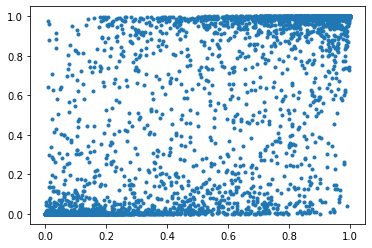

In [49]:
plt.plot(test['state'],test['state_blend'],'.')

In [53]:
test[['sequence','state_blend']].to_csv('xgb_blend1.csv', 
                                  index=False, header=['sequence','state'])

#### this has score of 9.111

### add the corr feature

In [54]:
def prep_corr(df, dfout):
    sensors = df.columns[3:]
    for sensor in sensors:
        X = df[sensor].values.reshape(-1,60).copy()
        mean = np.mean(X, axis=1)[:, np.newaxis]
        X = X - mean
        power = np.sum(np.power(X, 2), axis=1)
        power[power==0] = 1
        power = np.sqrt(power)[:,np.newaxis]
        X = X / power
        
        template = pd.read_csv('template_' + sensor + '.csv').values.reshape(1,-1)
        dfout[sensor+'_corr'] = np.max(correlate(template, X, mode='valid')[::-1], axis=1)

In [57]:
prep_corr(series, train)

In [58]:
train

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_skew,sensor_00_quantile_0.1,...,sensor_03_corr,sensor_04_corr,sensor_05_corr,sensor_06_corr,sensor_07_corr,sensor_08_corr,sensor_09_corr,sensor_10_corr,sensor_11_corr,sensor_12_corr
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,1.488052,-0.839722,...,0.139691,0.307225,0.294992,0.159480,0.181459,0.454950,0.200353,0.460667,0.260805,0.140798
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-0.683454,-1.415842,...,0.361034,0.250046,0.315479,0.250150,0.530328,0.344457,0.323870,0.579536,0.515457,0.458415
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,0.122688,-1.498377,...,0.167956,0.478490,0.490633,0.112306,0.410492,0.383307,0.235064,0.501383,0.225241,0.345895
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,0.306005,-1.855873,...,0.250848,0.378907,0.436343,0.157654,0.365340,0.328487,0.467942,0.524171,0.356032,0.311603
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,-0.216130,-2.203941,...,0.200227,0.490550,0.279390,0.284994,0.267245,0.373858,0.363488,0.357679,0.369057,0.480864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,0.069687,-1.763369,...,0.205955,0.405664,0.539009,0.105567,0.452906,0.417471,0.216181,0.580516,0.214420,0.431276
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,-1.690229,-0.944436,...,0.184173,0.331022,0.205103,0.176420,0.222221,0.409938,0.159549,0.289615,0.189063,0.341505
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.142272,-1.464760,...,0.205512,0.306209,0.351176,0.151529,0.238948,0.437131,0.253131,0.245200,0.171515,0.225972
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-0.259944,-1.144900,...,0.262448,0.316495,0.406378,0.107083,0.338021,0.679046,0.385791,0.309241,0.641825,0.363525


In [59]:
X, y = train.drop(columns=['sequence','subject','label']).values, train['label'].values
clfs_corr = train_xgboost(params, X, y)

{'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.4, 'random_state': 123}
[0]	validation_0-auc:0.82615
[1]	validation_0-auc:0.85316
[2]	validation_0-auc:0.86401
[3]	validation_0-auc:0.87207
[4]	validation_0-auc:0.87594
[5]	validation_0-auc:0.88392
[6]	validation_0-auc:0.89038
[7]	validation_0-auc:0.89521
[8]	validation_0-auc:0.89803
[9]	validation_0-auc:0.90101
[10]	validation_0-auc:0.90540
[11]	validation_0-auc:0.90920
[12]	validation_0-auc:0.91029
[13]	validation_0-auc:0.91125
[14]	validation_0-auc:0.91355
[15]	validation_0-auc:0.91426
[16]	validation_0-auc:0.91542
[17]	validation_0-auc:0.91671
[18]	validation_0-auc:0.91775
[19]	validation_0-auc:0.91892
[20]	validation_0-auc:0.91854
[21]	validation_0-auc:0.92051
[22]	validation_0-auc:0.92158
[23]	validation_0-auc:0.92187
[24]	validation_0-auc:0.92222
[25]	validation_0-auc:0.92189
[26]	validation_0-auc:0.92196
[27]	validation_0-auc:0.92347
[28]	validation_0-auc:0.92438
[29]	validation_0-au

[264]	validation_0-auc:0.94436
[265]	validation_0-auc:0.94435
[266]	validation_0-auc:0.94426
[267]	validation_0-auc:0.94425
[268]	validation_0-auc:0.94425
[269]	validation_0-auc:0.94425
[270]	validation_0-auc:0.94432
[271]	validation_0-auc:0.94431
[272]	validation_0-auc:0.94423
[273]	validation_0-auc:0.94413
[274]	validation_0-auc:0.94412
[275]	validation_0-auc:0.94415
[276]	validation_0-auc:0.94420
[277]	validation_0-auc:0.94428
[278]	validation_0-auc:0.94429
[279]	validation_0-auc:0.94415
[280]	validation_0-auc:0.94423
[281]	validation_0-auc:0.94423
[282]	validation_0-auc:0.94431
[283]	validation_0-auc:0.94437
[284]	validation_0-auc:0.94433
[285]	validation_0-auc:0.94426
[286]	validation_0-auc:0.94431
[287]	validation_0-auc:0.94418
[288]	validation_0-auc:0.94425
[289]	validation_0-auc:0.94427
[290]	validation_0-auc:0.94427
[291]	validation_0-auc:0.94441
[292]	validation_0-auc:0.94439
[293]	validation_0-auc:0.94439
[294]	validation_0-auc:0.94440
[295]	validation_0-auc:0.94440
retrain 

[236]	validation_0-auc:0.94423
[237]	validation_0-auc:0.94431
[238]	validation_0-auc:0.94434
[239]	validation_0-auc:0.94420
[240]	validation_0-auc:0.94418
[241]	validation_0-auc:0.94411
[242]	validation_0-auc:0.94410
[243]	validation_0-auc:0.94432
[244]	validation_0-auc:0.94448
[245]	validation_0-auc:0.94456
{'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.4, 'random_state': 123}
[0]	validation_0-auc:0.81871
[1]	validation_0-auc:0.83922
[2]	validation_0-auc:0.85393
[3]	validation_0-auc:0.86238
[4]	validation_0-auc:0.87062
[5]	validation_0-auc:0.87598
[6]	validation_0-auc:0.88249
[7]	validation_0-auc:0.88664
[8]	validation_0-auc:0.88869
[9]	validation_0-auc:0.89232
[10]	validation_0-auc:0.89688
[11]	validation_0-auc:0.89821
[12]	validation_0-auc:0.90087
[13]	validation_0-auc:0.90314
[14]	validation_0-auc:0.90402
[15]	validation_0-auc:0.90505
[16]	validation_0-auc:0.90490
[17]	validation_0-auc:0.90586
[18]	validation_0-auc:0.90657
[19]	valid

[254]	validation_0-auc:0.93647
[255]	validation_0-auc:0.93663
[256]	validation_0-auc:0.93653
[257]	validation_0-auc:0.93662
[258]	validation_0-auc:0.93661
[259]	validation_0-auc:0.93661
[260]	validation_0-auc:0.93665
[261]	validation_0-auc:0.93660
[262]	validation_0-auc:0.93671
[263]	validation_0-auc:0.93673
[264]	validation_0-auc:0.93671
[265]	validation_0-auc:0.93674
[266]	validation_0-auc:0.93682
[267]	validation_0-auc:0.93701
[268]	validation_0-auc:0.93705
[269]	validation_0-auc:0.93707
[270]	validation_0-auc:0.93706
[271]	validation_0-auc:0.93712
[272]	validation_0-auc:0.93702
[273]	validation_0-auc:0.93715
[274]	validation_0-auc:0.93716
[275]	validation_0-auc:0.93713
[276]	validation_0-auc:0.93715
[277]	validation_0-auc:0.93723
[278]	validation_0-auc:0.93736
[279]	validation_0-auc:0.93732
[280]	validation_0-auc:0.93738
[281]	validation_0-auc:0.93745
[282]	validation_0-auc:0.93744
[283]	validation_0-auc:0.93749
[284]	validation_0-auc:0.93746
[285]	validation_0-auc:0.93752
[286]	va

[519]	validation_0-auc:0.94085
[520]	validation_0-auc:0.94086
[521]	validation_0-auc:0.94087
[522]	validation_0-auc:0.94087
[523]	validation_0-auc:0.94086
[524]	validation_0-auc:0.94086
[525]	validation_0-auc:0.94086
[526]	validation_0-auc:0.94091
[527]	validation_0-auc:0.94092
[528]	validation_0-auc:0.94097
[529]	validation_0-auc:0.94103
[530]	validation_0-auc:0.94106
[531]	validation_0-auc:0.94104
[532]	validation_0-auc:0.94103
[533]	validation_0-auc:0.94108
[534]	validation_0-auc:0.94108
[535]	validation_0-auc:0.94111
[536]	validation_0-auc:0.94110
[537]	validation_0-auc:0.94114
[538]	validation_0-auc:0.94115
[539]	validation_0-auc:0.94118
[540]	validation_0-auc:0.94122
[541]	validation_0-auc:0.94120
[542]	validation_0-auc:0.94123
[543]	validation_0-auc:0.94125
[544]	validation_0-auc:0.94120
[545]	validation_0-auc:0.94122
[546]	validation_0-auc:0.94124
[547]	validation_0-auc:0.94120
[548]	validation_0-auc:0.94121
[549]	validation_0-auc:0.94123
[550]	validation_0-auc:0.94121
[551]	va

[784]	validation_0-auc:0.94238
[785]	validation_0-auc:0.94234
[786]	validation_0-auc:0.94235
[787]	validation_0-auc:0.94235
[788]	validation_0-auc:0.94236
[789]	validation_0-auc:0.94235
[790]	validation_0-auc:0.94232
[791]	validation_0-auc:0.94233
[792]	validation_0-auc:0.94236
[793]	validation_0-auc:0.94236
[794]	validation_0-auc:0.94233
[795]	validation_0-auc:0.94234
[796]	validation_0-auc:0.94231
[797]	validation_0-auc:0.94236
[798]	validation_0-auc:0.94234
[799]	validation_0-auc:0.94233
[800]	validation_0-auc:0.94233
[801]	validation_0-auc:0.94233
[802]	validation_0-auc:0.94231
[803]	validation_0-auc:0.94233
[804]	validation_0-auc:0.94231
[805]	validation_0-auc:0.94230
[806]	validation_0-auc:0.94230
[807]	validation_0-auc:0.94230
[808]	validation_0-auc:0.94231
[809]	validation_0-auc:0.94232
[810]	validation_0-auc:0.94231
[811]	validation_0-auc:0.94232
[812]	validation_0-auc:0.94230
[813]	validation_0-auc:0.94232
[814]	validation_0-auc:0.94231
[815]	validation_0-auc:0.94231
[816]	va

[217]	validation_0-auc:0.93496
[218]	validation_0-auc:0.93496
[219]	validation_0-auc:0.93491
[220]	validation_0-auc:0.93497
[221]	validation_0-auc:0.93509
[222]	validation_0-auc:0.93524
[223]	validation_0-auc:0.93535
[224]	validation_0-auc:0.93541
[225]	validation_0-auc:0.93549
[226]	validation_0-auc:0.93561
[227]	validation_0-auc:0.93559
[228]	validation_0-auc:0.93557
[229]	validation_0-auc:0.93575
[230]	validation_0-auc:0.93578
[231]	validation_0-auc:0.93561
[232]	validation_0-auc:0.93557
[233]	validation_0-auc:0.93570
[234]	validation_0-auc:0.93571
[235]	validation_0-auc:0.93591
[236]	validation_0-auc:0.93590
[237]	validation_0-auc:0.93588
[238]	validation_0-auc:0.93585
[239]	validation_0-auc:0.93580
[240]	validation_0-auc:0.93584
[241]	validation_0-auc:0.93594
[242]	validation_0-auc:0.93604
[243]	validation_0-auc:0.93616
[244]	validation_0-auc:0.93620
[245]	validation_0-auc:0.93639
[246]	validation_0-auc:0.93633
[247]	validation_0-auc:0.93638
[248]	validation_0-auc:0.93645
[249]	va

[482]	validation_0-auc:0.94038
[483]	validation_0-auc:0.94041
[484]	validation_0-auc:0.94041
[485]	validation_0-auc:0.94042
[486]	validation_0-auc:0.94042
[487]	validation_0-auc:0.94042
[488]	validation_0-auc:0.94047
[489]	validation_0-auc:0.94049
[490]	validation_0-auc:0.94047
[491]	validation_0-auc:0.94051
[492]	validation_0-auc:0.94055
[493]	validation_0-auc:0.94052
[494]	validation_0-auc:0.94054
[495]	validation_0-auc:0.94055
[496]	validation_0-auc:0.94051
[497]	validation_0-auc:0.94053
[498]	validation_0-auc:0.94053
[499]	validation_0-auc:0.94059
[500]	validation_0-auc:0.94063
[501]	validation_0-auc:0.94063
[502]	validation_0-auc:0.94066
[503]	validation_0-auc:0.94064
[504]	validation_0-auc:0.94067
[505]	validation_0-auc:0.94067
[506]	validation_0-auc:0.94067
[507]	validation_0-auc:0.94070
[508]	validation_0-auc:0.94070
[509]	validation_0-auc:0.94073
[510]	validation_0-auc:0.94073
[511]	validation_0-auc:0.94071
[512]	validation_0-auc:0.94070
[513]	validation_0-auc:0.94070
[514]	va

[747]	validation_0-auc:0.94218
[748]	validation_0-auc:0.94215
[749]	validation_0-auc:0.94216
[750]	validation_0-auc:0.94218
[751]	validation_0-auc:0.94215
[752]	validation_0-auc:0.94217
[753]	validation_0-auc:0.94221
[754]	validation_0-auc:0.94220
[755]	validation_0-auc:0.94216
[756]	validation_0-auc:0.94216
[757]	validation_0-auc:0.94220
[758]	validation_0-auc:0.94220
[759]	validation_0-auc:0.94221
[760]	validation_0-auc:0.94223
[761]	validation_0-auc:0.94224
[762]	validation_0-auc:0.94222
[763]	validation_0-auc:0.94222
[764]	validation_0-auc:0.94220
[765]	validation_0-auc:0.94222
[766]	validation_0-auc:0.94221
[767]	validation_0-auc:0.94222
[768]	validation_0-auc:0.94223
[769]	validation_0-auc:0.94224
[770]	validation_0-auc:0.94226
[771]	validation_0-auc:0.94228
[772]	validation_0-auc:0.94227
[773]	validation_0-auc:0.94225
[774]	validation_0-auc:0.94227
[775]	validation_0-auc:0.94225
[776]	validation_0-auc:0.94227
[777]	validation_0-auc:0.94231
[778]	validation_0-auc:0.94233
[779]	va

[226]	validation_0-auc:0.94049
[227]	validation_0-auc:0.94046
[228]	validation_0-auc:0.94066
[229]	validation_0-auc:0.94065
[230]	validation_0-auc:0.94061
[231]	validation_0-auc:0.94077
[232]	validation_0-auc:0.94070
[233]	validation_0-auc:0.94074
[234]	validation_0-auc:0.94075
[235]	validation_0-auc:0.94077
[236]	validation_0-auc:0.94084
[237]	validation_0-auc:0.94076
[238]	validation_0-auc:0.94094
[239]	validation_0-auc:0.94096
[240]	validation_0-auc:0.94099
[241]	validation_0-auc:0.94111
[242]	validation_0-auc:0.94104
[243]	validation_0-auc:0.94120
[244]	validation_0-auc:0.94126
[245]	validation_0-auc:0.94131
[246]	validation_0-auc:0.94141
[247]	validation_0-auc:0.94142
[248]	validation_0-auc:0.94149
[249]	validation_0-auc:0.94154
[250]	validation_0-auc:0.94155
[251]	validation_0-auc:0.94164
[252]	validation_0-auc:0.94159
[253]	validation_0-auc:0.94160
[254]	validation_0-auc:0.94158
[255]	validation_0-auc:0.94158
[256]	validation_0-auc:0.94151
[257]	validation_0-auc:0.94142
[258]	va

[491]	validation_0-auc:0.94502
[492]	validation_0-auc:0.94506
[493]	validation_0-auc:0.94507
[494]	validation_0-auc:0.94507
[495]	validation_0-auc:0.94507
[496]	validation_0-auc:0.94509
[497]	validation_0-auc:0.94518
[498]	validation_0-auc:0.94519
[499]	validation_0-auc:0.94522
[500]	validation_0-auc:0.94527
[501]	validation_0-auc:0.94522
[502]	validation_0-auc:0.94527
[503]	validation_0-auc:0.94522
[504]	validation_0-auc:0.94525
[505]	validation_0-auc:0.94527
[506]	validation_0-auc:0.94530
[507]	validation_0-auc:0.94532
[508]	validation_0-auc:0.94535
[509]	validation_0-auc:0.94538
[510]	validation_0-auc:0.94540
[511]	validation_0-auc:0.94539
[512]	validation_0-auc:0.94539
[513]	validation_0-auc:0.94539
[514]	validation_0-auc:0.94537
[515]	validation_0-auc:0.94540
[516]	validation_0-auc:0.94542
[517]	validation_0-auc:0.94546
[518]	validation_0-auc:0.94546
[519]	validation_0-auc:0.94548
[520]	validation_0-auc:0.94548
[521]	validation_0-auc:0.94550
[522]	validation_0-auc:0.94548
[523]	va

[35]	validation_0-auc:0.92482
[36]	validation_0-auc:0.92508
[37]	validation_0-auc:0.92502
[38]	validation_0-auc:0.92479
[39]	validation_0-auc:0.92502
[40]	validation_0-auc:0.92581
[41]	validation_0-auc:0.92578
[42]	validation_0-auc:0.92620
[43]	validation_0-auc:0.92612
[44]	validation_0-auc:0.92658
[45]	validation_0-auc:0.92719
[46]	validation_0-auc:0.92797
[47]	validation_0-auc:0.92803
[48]	validation_0-auc:0.92798
[49]	validation_0-auc:0.92821
[50]	validation_0-auc:0.92899
[51]	validation_0-auc:0.92918
[52]	validation_0-auc:0.92951
[53]	validation_0-auc:0.92910
[54]	validation_0-auc:0.92932
[55]	validation_0-auc:0.92938
[56]	validation_0-auc:0.92966
[57]	validation_0-auc:0.92945
[58]	validation_0-auc:0.92982
[59]	validation_0-auc:0.93060
[60]	validation_0-auc:0.93103
[61]	validation_0-auc:0.93083
[62]	validation_0-auc:0.93047
[63]	validation_0-auc:0.93036
[64]	validation_0-auc:0.93043
[65]	validation_0-auc:0.93042
[66]	validation_0-auc:0.93046
[67]	validation_0-auc:0.93083
[68]	valid

[302]	validation_0-auc:0.94209
[303]	validation_0-auc:0.94217
[304]	validation_0-auc:0.94220
[305]	validation_0-auc:0.94207
[306]	validation_0-auc:0.94212
[307]	validation_0-auc:0.94223
[308]	validation_0-auc:0.94223
[309]	validation_0-auc:0.94229
[310]	validation_0-auc:0.94223
[311]	validation_0-auc:0.94211
[312]	validation_0-auc:0.94220
[313]	validation_0-auc:0.94230
[314]	validation_0-auc:0.94238
[315]	validation_0-auc:0.94238
[316]	validation_0-auc:0.94242
[317]	validation_0-auc:0.94245
[318]	validation_0-auc:0.94243
[319]	validation_0-auc:0.94250
[320]	validation_0-auc:0.94251
[321]	validation_0-auc:0.94259
[322]	validation_0-auc:0.94262
[323]	validation_0-auc:0.94266
[324]	validation_0-auc:0.94269
[325]	validation_0-auc:0.94278
[326]	validation_0-auc:0.94280
[327]	validation_0-auc:0.94277
[328]	validation_0-auc:0.94288
[329]	validation_0-auc:0.94283
[330]	validation_0-auc:0.94280
[331]	validation_0-auc:0.94297
[332]	validation_0-auc:0.94301
[333]	validation_0-auc:0.94300
[334]	va

[567]	validation_0-auc:0.94571
[568]	validation_0-auc:0.94570
[569]	validation_0-auc:0.94570
[570]	validation_0-auc:0.94569
[571]	validation_0-auc:0.94570
[572]	validation_0-auc:0.94571
[573]	validation_0-auc:0.94569
[574]	validation_0-auc:0.94572
[575]	validation_0-auc:0.94572
[576]	validation_0-auc:0.94569
[577]	validation_0-auc:0.94573
[578]	validation_0-auc:0.94569
[579]	validation_0-auc:0.94571
[580]	validation_0-auc:0.94572
[581]	validation_0-auc:0.94571
[582]	validation_0-auc:0.94573
[583]	validation_0-auc:0.94574
[584]	validation_0-auc:0.94571
[585]	validation_0-auc:0.94577
[586]	validation_0-auc:0.94581
[587]	validation_0-auc:0.94580
[588]	validation_0-auc:0.94583
[589]	validation_0-auc:0.94582
[590]	validation_0-auc:0.94583
[591]	validation_0-auc:0.94578
[592]	validation_0-auc:0.94578
[593]	validation_0-auc:0.94579
[594]	validation_0-auc:0.94584
[595]	validation_0-auc:0.94584
[596]	validation_0-auc:0.94585
[597]	validation_0-auc:0.94584
[598]	validation_0-auc:0.94589
[599]	va

[159]	validation_0-auc:0.93128
[160]	validation_0-auc:0.93126
[161]	validation_0-auc:0.93148
[162]	validation_0-auc:0.93171
[163]	validation_0-auc:0.93153
[164]	validation_0-auc:0.93168
[165]	validation_0-auc:0.93181
[166]	validation_0-auc:0.93171
[167]	validation_0-auc:0.93173
[168]	validation_0-auc:0.93157
[169]	validation_0-auc:0.93162
[170]	validation_0-auc:0.93158
[171]	validation_0-auc:0.93144
[172]	validation_0-auc:0.93148
[173]	validation_0-auc:0.93155
[174]	validation_0-auc:0.93145
[175]	validation_0-auc:0.93148
[176]	validation_0-auc:0.93154
[177]	validation_0-auc:0.93167
[178]	validation_0-auc:0.93174
[179]	validation_0-auc:0.93182
[180]	validation_0-auc:0.93174
[181]	validation_0-auc:0.93171
[182]	validation_0-auc:0.93178
[183]	validation_0-auc:0.93179
[184]	validation_0-auc:0.93185
[185]	validation_0-auc:0.93205
[186]	validation_0-auc:0.93202
[187]	validation_0-auc:0.93206
[188]	validation_0-auc:0.93211
[189]	validation_0-auc:0.93213
[190]	validation_0-auc:0.93224
[191]	va

[424]	validation_0-auc:0.93595
[425]	validation_0-auc:0.93601
[426]	validation_0-auc:0.93596
[427]	validation_0-auc:0.93593
[428]	validation_0-auc:0.93593
[429]	validation_0-auc:0.93585
[430]	validation_0-auc:0.93592
[431]	validation_0-auc:0.93598
[432]	validation_0-auc:0.93600
[433]	validation_0-auc:0.93590
[434]	validation_0-auc:0.93587
[435]	validation_0-auc:0.93588
[436]	validation_0-auc:0.93589
[437]	validation_0-auc:0.93589
[438]	validation_0-auc:0.93582
[439]	validation_0-auc:0.93585
[440]	validation_0-auc:0.93582
[441]	validation_0-auc:0.93580
[442]	validation_0-auc:0.93582
[443]	validation_0-auc:0.93589
[444]	validation_0-auc:0.93590
[445]	validation_0-auc:0.93591
[446]	validation_0-auc:0.93588
[447]	validation_0-auc:0.93592
[448]	validation_0-auc:0.93595
[449]	validation_0-auc:0.93593
[450]	validation_0-auc:0.93590
[451]	validation_0-auc:0.93594
[452]	validation_0-auc:0.93599
[453]	validation_0-auc:0.93599
[454]	validation_0-auc:0.93595
[455]	validation_0-auc:0.93595
[456]	va

[225]	validation_0-auc:0.93311
[226]	validation_0-auc:0.93305
[227]	validation_0-auc:0.93305
[228]	validation_0-auc:0.93304
[229]	validation_0-auc:0.93299
[230]	validation_0-auc:0.93299
[231]	validation_0-auc:0.93289
[232]	validation_0-auc:0.93297
[233]	validation_0-auc:0.93297
[234]	validation_0-auc:0.93289
[235]	validation_0-auc:0.93297
[236]	validation_0-auc:0.93301
[237]	validation_0-auc:0.93301
[238]	validation_0-auc:0.93307
[239]	validation_0-auc:0.93311
[240]	validation_0-auc:0.93325
[241]	validation_0-auc:0.93310
[242]	validation_0-auc:0.93318
[243]	validation_0-auc:0.93328
[244]	validation_0-auc:0.93336
[245]	validation_0-auc:0.93341
[246]	validation_0-auc:0.93345
[247]	validation_0-auc:0.93348
[248]	validation_0-auc:0.93330
[249]	validation_0-auc:0.93330
[250]	validation_0-auc:0.93336
[251]	validation_0-auc:0.93342
[252]	validation_0-auc:0.93337
[253]	validation_0-auc:0.93348
[254]	validation_0-auc:0.93339
[255]	validation_0-auc:0.93340
[256]	validation_0-auc:0.93339
[257]	va

[70]	validation_0-auc:0.93649
[71]	validation_0-auc:0.93656
[72]	validation_0-auc:0.93625
[73]	validation_0-auc:0.93670
[74]	validation_0-auc:0.93661
[75]	validation_0-auc:0.93658
[76]	validation_0-auc:0.93658
[77]	validation_0-auc:0.93664
[78]	validation_0-auc:0.93692
[79]	validation_0-auc:0.93722
[80]	validation_0-auc:0.93762
[81]	validation_0-auc:0.93833
[82]	validation_0-auc:0.93865
[83]	validation_0-auc:0.93875
[84]	validation_0-auc:0.93873
[85]	validation_0-auc:0.93874
[86]	validation_0-auc:0.93863
[87]	validation_0-auc:0.93867
[88]	validation_0-auc:0.93848
[89]	validation_0-auc:0.93885
[90]	validation_0-auc:0.93906
[91]	validation_0-auc:0.93883
[92]	validation_0-auc:0.93895
[93]	validation_0-auc:0.93901
[94]	validation_0-auc:0.93902
[95]	validation_0-auc:0.93917
[96]	validation_0-auc:0.93934
[97]	validation_0-auc:0.93940
[98]	validation_0-auc:0.93952
[99]	validation_0-auc:0.93928
[100]	validation_0-auc:0.93912
[101]	validation_0-auc:0.93916
[102]	validation_0-auc:0.93923
[103]	v

[336]	validation_0-auc:0.95073
[337]	validation_0-auc:0.95066
[338]	validation_0-auc:0.95068
[339]	validation_0-auc:0.95069
[340]	validation_0-auc:0.95081
[341]	validation_0-auc:0.95079
[342]	validation_0-auc:0.95079
[343]	validation_0-auc:0.95072
[344]	validation_0-auc:0.95078
[345]	validation_0-auc:0.95069
[346]	validation_0-auc:0.95068
[347]	validation_0-auc:0.95071
[348]	validation_0-auc:0.95062
[349]	validation_0-auc:0.95070
[350]	validation_0-auc:0.95072
[351]	validation_0-auc:0.95078
[352]	validation_0-auc:0.95074
[353]	validation_0-auc:0.95076
[354]	validation_0-auc:0.95069
[355]	validation_0-auc:0.95075
[356]	validation_0-auc:0.95083
[357]	validation_0-auc:0.95087
[358]	validation_0-auc:0.95094
[359]	validation_0-auc:0.95090
[360]	validation_0-auc:0.95101
[361]	validation_0-auc:0.95105
[362]	validation_0-auc:0.95098
[363]	validation_0-auc:0.95102
[364]	validation_0-auc:0.95107
[365]	validation_0-auc:0.95117
[366]	validation_0-auc:0.95116
[367]	validation_0-auc:0.95122
[368]	va

[601]	validation_0-auc:0.95272
[602]	validation_0-auc:0.95274
[603]	validation_0-auc:0.95278
[604]	validation_0-auc:0.95276
[605]	validation_0-auc:0.95280
[606]	validation_0-auc:0.95279
[607]	validation_0-auc:0.95281
[608]	validation_0-auc:0.95283
[609]	validation_0-auc:0.95280
[610]	validation_0-auc:0.95279
[611]	validation_0-auc:0.95279
[612]	validation_0-auc:0.95282
[613]	validation_0-auc:0.95282
[614]	validation_0-auc:0.95282
[615]	validation_0-auc:0.95284
[616]	validation_0-auc:0.95282
[617]	validation_0-auc:0.95282
[618]	validation_0-auc:0.95281
[619]	validation_0-auc:0.95283
[620]	validation_0-auc:0.95282
[621]	validation_0-auc:0.95285
[622]	validation_0-auc:0.95283
[623]	validation_0-auc:0.95281
[624]	validation_0-auc:0.95277
[625]	validation_0-auc:0.95281
[626]	validation_0-auc:0.95280
[627]	validation_0-auc:0.95280
[628]	validation_0-auc:0.95279
[629]	validation_0-auc:0.95277
[630]	validation_0-auc:0.95280
[631]	validation_0-auc:0.95278
[632]	validation_0-auc:0.95279
[633]	va

[866]	validation_0-auc:0.95367
[867]	validation_0-auc:0.95366
[868]	validation_0-auc:0.95368
[869]	validation_0-auc:0.95367
[870]	validation_0-auc:0.95367
[871]	validation_0-auc:0.95368
[872]	validation_0-auc:0.95366
[873]	validation_0-auc:0.95369
[874]	validation_0-auc:0.95366
[875]	validation_0-auc:0.95367
[876]	validation_0-auc:0.95365
[877]	validation_0-auc:0.95366
[878]	validation_0-auc:0.95366
[879]	validation_0-auc:0.95367
[880]	validation_0-auc:0.95366
[881]	validation_0-auc:0.95369
[882]	validation_0-auc:0.95364
[883]	validation_0-auc:0.95363
[884]	validation_0-auc:0.95362
[885]	validation_0-auc:0.95362
[886]	validation_0-auc:0.95362
[887]	validation_0-auc:0.95361
[888]	validation_0-auc:0.95362
[889]	validation_0-auc:0.95363
[890]	validation_0-auc:0.95361
[891]	validation_0-auc:0.95362
[892]	validation_0-auc:0.95363
[893]	validation_0-auc:0.95362
[894]	validation_0-auc:0.95360
[895]	validation_0-auc:0.95361
[896]	validation_0-auc:0.95359
[897]	validation_0-auc:0.95361
[898]	va

[224]	validation_0-auc:0.94786
[225]	validation_0-auc:0.94798
[226]	validation_0-auc:0.94796
[227]	validation_0-auc:0.94800
[228]	validation_0-auc:0.94813
[229]	validation_0-auc:0.94825
[230]	validation_0-auc:0.94826
[231]	validation_0-auc:0.94829
[232]	validation_0-auc:0.94847
[233]	validation_0-auc:0.94844
[234]	validation_0-auc:0.94842
[235]	validation_0-auc:0.94840
[236]	validation_0-auc:0.94839
[237]	validation_0-auc:0.94847
[238]	validation_0-auc:0.94849
[239]	validation_0-auc:0.94868
[240]	validation_0-auc:0.94865
[241]	validation_0-auc:0.94869
[242]	validation_0-auc:0.94866
[243]	validation_0-auc:0.94860
[244]	validation_0-auc:0.94854
[245]	validation_0-auc:0.94857
[246]	validation_0-auc:0.94859
[247]	validation_0-auc:0.94864
[248]	validation_0-auc:0.94863
[249]	validation_0-auc:0.94864
[250]	validation_0-auc:0.94870
[251]	validation_0-auc:0.94870
[252]	validation_0-auc:0.94860
[253]	validation_0-auc:0.94860
[254]	validation_0-auc:0.94872
[255]	validation_0-auc:0.94884
[256]	va

[489]	validation_0-auc:0.95191
[490]	validation_0-auc:0.95190
[491]	validation_0-auc:0.95193
[492]	validation_0-auc:0.95190
[493]	validation_0-auc:0.95190
[494]	validation_0-auc:0.95187
[495]	validation_0-auc:0.95183
[496]	validation_0-auc:0.95188
[497]	validation_0-auc:0.95191
[498]	validation_0-auc:0.95190
[499]	validation_0-auc:0.95192
[500]	validation_0-auc:0.95197
[501]	validation_0-auc:0.95198
[502]	validation_0-auc:0.95203
[503]	validation_0-auc:0.95201
[504]	validation_0-auc:0.95201
[505]	validation_0-auc:0.95202
[506]	validation_0-auc:0.95197
[507]	validation_0-auc:0.95200
[508]	validation_0-auc:0.95199
[509]	validation_0-auc:0.95198
[510]	validation_0-auc:0.95201
[511]	validation_0-auc:0.95201
[512]	validation_0-auc:0.95201
[513]	validation_0-auc:0.95203
[514]	validation_0-auc:0.95207
[515]	validation_0-auc:0.95206
[516]	validation_0-auc:0.95210
[517]	validation_0-auc:0.95207
[518]	validation_0-auc:0.95208
[519]	validation_0-auc:0.95209
[520]	validation_0-auc:0.95205
[521]	va

[754]	validation_0-auc:0.95333
[755]	validation_0-auc:0.95334
[756]	validation_0-auc:0.95334
[757]	validation_0-auc:0.95336
[758]	validation_0-auc:0.95336
[759]	validation_0-auc:0.95336
[760]	validation_0-auc:0.95337
[761]	validation_0-auc:0.95337
[762]	validation_0-auc:0.95338
[763]	validation_0-auc:0.95340
[764]	validation_0-auc:0.95339
[765]	validation_0-auc:0.95339
[766]	validation_0-auc:0.95341
[767]	validation_0-auc:0.95339
[768]	validation_0-auc:0.95339
[769]	validation_0-auc:0.95340
[770]	validation_0-auc:0.95341
[771]	validation_0-auc:0.95340
[772]	validation_0-auc:0.95338
[773]	validation_0-auc:0.95339
[774]	validation_0-auc:0.95340
[775]	validation_0-auc:0.95341
[776]	validation_0-auc:0.95343
[777]	validation_0-auc:0.95344
[778]	validation_0-auc:0.95343
[779]	validation_0-auc:0.95347
[780]	validation_0-auc:0.95346
[781]	validation_0-auc:0.95346
[782]	validation_0-auc:0.95344
[783]	validation_0-auc:0.95345
[784]	validation_0-auc:0.95348
[785]	validation_0-auc:0.95350
[786]	va

In [61]:
blend_corr = train_blend(clfs_corr, X, y)

In [69]:
X.shape

(25968, 247)

In [62]:
series_test = pd.read_csv('test.csv')

In [63]:
test

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_skew,sensor_00_quantile_0.1,...,sensor_12_subject_std,sensor_12_subject_median,sensor_12_subject_mad,sensor_12_subject_min,sensor_12_subject_max,sensor_12_subject_skew,sensor_12_subject_quantile_0.1,sensor_12_subject_quantile_0.9,state,state_blend
0,25968,684,-0.002602,1.091741,-0.002318,0.732741,-4.950541,3.146832,-0.927921,-0.990881,...,0.357927,-0.001705,0.257374,-3.095055,2.274936,-0.373078,-0.400256,0.419011,9.996876e-01,0.999822
1,25969,935,0.028516,1.450040,-0.015842,0.848916,-3.675425,5.816074,1.644888,-1.593818,...,0.666448,-0.044970,0.540439,-2.149616,2.197357,0.122792,-0.851662,0.871739,9.999501e-01,0.999826
2,25970,924,0.057664,5.083618,1.079212,4.023308,-15.005410,12.306028,-0.634247,-6.078284,...,45.897352,-1.936275,34.328376,-182.180307,253.685422,0.287835,-50.305712,51.781841,8.120131e-06,0.000052
3,25971,769,-0.004791,0.914917,-0.033617,0.687991,-2.465997,2.876352,0.218435,-1.114065,...,1.050432,-0.070546,0.666881,-17.872975,19.086957,0.244525,-0.880648,1.068670,7.742286e-01,0.998746
4,25972,764,-0.001443,2.783685,-0.171947,1.083572,-9.974498,17.295209,3.383219,-1.018006,...,130.641157,12.570546,106.631204,-518.899403,436.830350,-0.304521,-177.718073,161.534953,9.820708e-01,0.999367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12213,38181,980,-0.047746,1.105589,-0.101236,0.673399,-3.358578,5.135240,1.537281,-0.889490,...,79.322486,3.027707,64.917644,-258.855499,259.353367,-0.062768,-103.329454,100.520290,9.999018e-01,0.999824
12214,38182,915,-0.016473,4.500443,-0.020866,1.734531,-13.154560,26.738794,2.817622,-1.357573,...,1.167783,0.000000,0.335635,-17.114663,24.105286,6.262417,-0.381586,0.350384,8.843918e-01,0.363127
12215,38183,872,-0.005500,2.082974,-0.093895,1.264870,-4.977589,8.312983,1.434987,-1.565997,...,0.449220,0.000639,0.294347,-3.756181,3.396846,-0.353997,-0.445908,0.451876,5.816118e-01,0.090919
12216,38184,835,-0.032573,3.185580,0.421947,2.558474,-8.993818,6.951314,-0.172654,-3.605023,...,0.703118,-0.088875,0.564736,-2.856351,2.659420,0.255825,-0.812020,0.988576,2.545524e-07,0.000051


In [64]:
prep_corr(series_test, test)

In [71]:
train.shape

(25968, 250)

In [74]:
X_test = test.drop(columns=['sequence','subject','state','state_blend']).values

In [75]:
X_test.shape

(12218, 247)

In [76]:
test['state_blend_corr'] = predict_blend(clfs_corr, X_test, blend_corr)

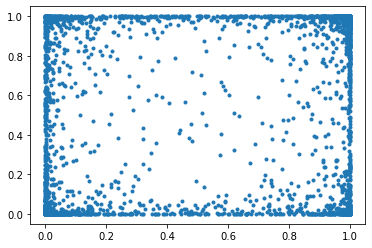

In [77]:
plt.plot(test['state_blend'],test['state_blend_corr'],'.')

In [78]:
test[['sequence','state_blend_corr']].to_csv('xgb_blend1_corr.csv', 
                                  index=False, header=['sequence','state'])

#### this has a score of 0.919

In [79]:
X.shape

(25968, 247)

In [84]:
X_xgb, X_blend, y_xgb, y_blend = train_test_split(X,y,test_size=0.1)

In [86]:
X_xgb.shape, X_blend.shape

((23371, 247), (2597, 247))

In [87]:
clfs_corr_v2 = train_xgboost(params, X_xgb, y_xgb)

{'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.4, 'random_state': 123}
[0]	validation_0-auc:0.83156
[1]	validation_0-auc:0.84791
[2]	validation_0-auc:0.86038
[3]	validation_0-auc:0.86851
[4]	validation_0-auc:0.87197
[5]	validation_0-auc:0.88209
[6]	validation_0-auc:0.88348
[7]	validation_0-auc:0.88778
[8]	validation_0-auc:0.89039
[9]	validation_0-auc:0.89343
[10]	validation_0-auc:0.89564
[11]	validation_0-auc:0.89721
[12]	validation_0-auc:0.90027
[13]	validation_0-auc:0.90097
[14]	validation_0-auc:0.90282
[15]	validation_0-auc:0.90225
[16]	validation_0-auc:0.90324
[17]	validation_0-auc:0.90599
[18]	validation_0-auc:0.90739
[19]	validation_0-auc:0.90748
[20]	validation_0-auc:0.90884
[21]	validation_0-auc:0.91067
[22]	validation_0-auc:0.91138
[23]	validation_0-auc:0.91230
[24]	validation_0-auc:0.91259
[25]	validation_0-auc:0.91258
[26]	validation_0-auc:0.91185
[27]	validation_0-auc:0.91348
[28]	validation_0-auc:0.91467
[29]	validation_0-au

[264]	validation_0-auc:0.93347
[265]	validation_0-auc:0.93353
[266]	validation_0-auc:0.93351
[267]	validation_0-auc:0.93339
[268]	validation_0-auc:0.93339
[269]	validation_0-auc:0.93341
[270]	validation_0-auc:0.93341
[271]	validation_0-auc:0.93349
[272]	validation_0-auc:0.93345
[273]	validation_0-auc:0.93341
[274]	validation_0-auc:0.93351
[275]	validation_0-auc:0.93368
[276]	validation_0-auc:0.93377
[277]	validation_0-auc:0.93376
[278]	validation_0-auc:0.93383
[279]	validation_0-auc:0.93374
[280]	validation_0-auc:0.93387
[281]	validation_0-auc:0.93395
[282]	validation_0-auc:0.93401
[283]	validation_0-auc:0.93403
[284]	validation_0-auc:0.93394
[285]	validation_0-auc:0.93393
[286]	validation_0-auc:0.93388
[287]	validation_0-auc:0.93398
[288]	validation_0-auc:0.93405
[289]	validation_0-auc:0.93408
[290]	validation_0-auc:0.93415
[291]	validation_0-auc:0.93409
[292]	validation_0-auc:0.93416
[293]	validation_0-auc:0.93418
[294]	validation_0-auc:0.93414
[295]	validation_0-auc:0.93417
[296]	va

[529]	validation_0-auc:0.93676
[530]	validation_0-auc:0.93676
[531]	validation_0-auc:0.93683
[532]	validation_0-auc:0.93678
[533]	validation_0-auc:0.93675
[534]	validation_0-auc:0.93676
[535]	validation_0-auc:0.93679
[536]	validation_0-auc:0.93677
[537]	validation_0-auc:0.93677
[538]	validation_0-auc:0.93677
[539]	validation_0-auc:0.93678
[540]	validation_0-auc:0.93672
[541]	validation_0-auc:0.93677
[542]	validation_0-auc:0.93681
[543]	validation_0-auc:0.93687
[544]	validation_0-auc:0.93688
[545]	validation_0-auc:0.93688
[546]	validation_0-auc:0.93693
[547]	validation_0-auc:0.93695
[548]	validation_0-auc:0.93695
[549]	validation_0-auc:0.93699
[550]	validation_0-auc:0.93696
[551]	validation_0-auc:0.93701
[552]	validation_0-auc:0.93700
[553]	validation_0-auc:0.93699
[554]	validation_0-auc:0.93702
[555]	validation_0-auc:0.93702
[556]	validation_0-auc:0.93704
[557]	validation_0-auc:0.93698
[558]	validation_0-auc:0.93701
[559]	validation_0-auc:0.93701
[560]	validation_0-auc:0.93699
[561]	va

[126]	validation_0-auc:0.92747
[127]	validation_0-auc:0.92759
[128]	validation_0-auc:0.92759
[129]	validation_0-auc:0.92741
[130]	validation_0-auc:0.92741
[131]	validation_0-auc:0.92773
[132]	validation_0-auc:0.92780
[133]	validation_0-auc:0.92787
[134]	validation_0-auc:0.92780
[135]	validation_0-auc:0.92794
[136]	validation_0-auc:0.92788
[137]	validation_0-auc:0.92785
[138]	validation_0-auc:0.92784
[139]	validation_0-auc:0.92812
[140]	validation_0-auc:0.92813
[141]	validation_0-auc:0.92809
[142]	validation_0-auc:0.92810
[143]	validation_0-auc:0.92822
[144]	validation_0-auc:0.92844
[145]	validation_0-auc:0.92822
[146]	validation_0-auc:0.92825
[147]	validation_0-auc:0.92826
[148]	validation_0-auc:0.92804
[149]	validation_0-auc:0.92843
[150]	validation_0-auc:0.92835
[151]	validation_0-auc:0.92822
[152]	validation_0-auc:0.92817
[153]	validation_0-auc:0.92822
[154]	validation_0-auc:0.92834
[155]	validation_0-auc:0.92840
[156]	validation_0-auc:0.92836
[157]	validation_0-auc:0.92844
[158]	va

[391]	validation_0-auc:0.93531
[392]	validation_0-auc:0.93532
[393]	validation_0-auc:0.93532
[394]	validation_0-auc:0.93527
[395]	validation_0-auc:0.93532
[396]	validation_0-auc:0.93533
[397]	validation_0-auc:0.93530
[398]	validation_0-auc:0.93531
[399]	validation_0-auc:0.93530
[400]	validation_0-auc:0.93531
[401]	validation_0-auc:0.93537
[402]	validation_0-auc:0.93535
[403]	validation_0-auc:0.93541
[404]	validation_0-auc:0.93540
[405]	validation_0-auc:0.93546
[406]	validation_0-auc:0.93552
[407]	validation_0-auc:0.93556
[408]	validation_0-auc:0.93563
[409]	validation_0-auc:0.93558
[410]	validation_0-auc:0.93549
[411]	validation_0-auc:0.93551
[412]	validation_0-auc:0.93551
[413]	validation_0-auc:0.93553
[414]	validation_0-auc:0.93563
[415]	validation_0-auc:0.93560
[416]	validation_0-auc:0.93568
[417]	validation_0-auc:0.93573
[418]	validation_0-auc:0.93578
[419]	validation_0-auc:0.93576
[420]	validation_0-auc:0.93578
[421]	validation_0-auc:0.93581
[422]	validation_0-auc:0.93584
[423]	va

[31]	validation_0-auc:0.91668
[32]	validation_0-auc:0.91725
[33]	validation_0-auc:0.91644
[34]	validation_0-auc:0.91651
[35]	validation_0-auc:0.91689
[36]	validation_0-auc:0.91718
[37]	validation_0-auc:0.91736
[38]	validation_0-auc:0.91736
[39]	validation_0-auc:0.91736
[40]	validation_0-auc:0.91758
[41]	validation_0-auc:0.91792
[42]	validation_0-auc:0.91846
[43]	validation_0-auc:0.91843
[44]	validation_0-auc:0.91836
[45]	validation_0-auc:0.91913
[46]	validation_0-auc:0.91906
[47]	validation_0-auc:0.91897
[48]	validation_0-auc:0.91939
[49]	validation_0-auc:0.91931
[50]	validation_0-auc:0.91942
[51]	validation_0-auc:0.91977
[52]	validation_0-auc:0.92025
[53]	validation_0-auc:0.92046
[54]	validation_0-auc:0.92028
[55]	validation_0-auc:0.92046
[56]	validation_0-auc:0.92079
[57]	validation_0-auc:0.92121
[58]	validation_0-auc:0.92123
[59]	validation_0-auc:0.92175
[60]	validation_0-auc:0.92197
[61]	validation_0-auc:0.92193
[62]	validation_0-auc:0.92225
[63]	validation_0-auc:0.92223
[64]	valid

[298]	validation_0-auc:0.93353
[299]	validation_0-auc:0.93354
[300]	validation_0-auc:0.93360
[301]	validation_0-auc:0.93358
[302]	validation_0-auc:0.93367
[303]	validation_0-auc:0.93361
[304]	validation_0-auc:0.93366
[305]	validation_0-auc:0.93360
[306]	validation_0-auc:0.93365
[307]	validation_0-auc:0.93359
[308]	validation_0-auc:0.93358
[309]	validation_0-auc:0.93367
[310]	validation_0-auc:0.93376
[311]	validation_0-auc:0.93379
[312]	validation_0-auc:0.93379
[313]	validation_0-auc:0.93379
[314]	validation_0-auc:0.93387
[315]	validation_0-auc:0.93383
[316]	validation_0-auc:0.93392
[317]	validation_0-auc:0.93404
[318]	validation_0-auc:0.93404
[319]	validation_0-auc:0.93415
[320]	validation_0-auc:0.93413
[321]	validation_0-auc:0.93415
[322]	validation_0-auc:0.93418
[323]	validation_0-auc:0.93420
[324]	validation_0-auc:0.93416
[325]	validation_0-auc:0.93409
[326]	validation_0-auc:0.93415
[327]	validation_0-auc:0.93407
[328]	validation_0-auc:0.93409
[329]	validation_0-auc:0.93418
[330]	va

[563]	validation_0-auc:0.93706
[564]	validation_0-auc:0.93709
[565]	validation_0-auc:0.93713
[566]	validation_0-auc:0.93711
[567]	validation_0-auc:0.93712
[568]	validation_0-auc:0.93715
[569]	validation_0-auc:0.93712
[570]	validation_0-auc:0.93715
[571]	validation_0-auc:0.93714
[572]	validation_0-auc:0.93714
[573]	validation_0-auc:0.93715
[574]	validation_0-auc:0.93713
[575]	validation_0-auc:0.93717
[576]	validation_0-auc:0.93716
[577]	validation_0-auc:0.93719
[578]	validation_0-auc:0.93724
[579]	validation_0-auc:0.93726
[580]	validation_0-auc:0.93726
[581]	validation_0-auc:0.93728
[582]	validation_0-auc:0.93731
[583]	validation_0-auc:0.93734
[584]	validation_0-auc:0.93731
[585]	validation_0-auc:0.93732
[586]	validation_0-auc:0.93729
[587]	validation_0-auc:0.93728
[588]	validation_0-auc:0.93726
[589]	validation_0-auc:0.93727
[590]	validation_0-auc:0.93733
[591]	validation_0-auc:0.93733
[592]	validation_0-auc:0.93735
[593]	validation_0-auc:0.93735
[594]	validation_0-auc:0.93732
[595]	va

[828]	validation_0-auc:0.93823
[829]	validation_0-auc:0.93823
[830]	validation_0-auc:0.93822
[831]	validation_0-auc:0.93822
[832]	validation_0-auc:0.93825
[833]	validation_0-auc:0.93825
[834]	validation_0-auc:0.93824
[835]	validation_0-auc:0.93826
[836]	validation_0-auc:0.93827
[837]	validation_0-auc:0.93829
[838]	validation_0-auc:0.93828
[839]	validation_0-auc:0.93827
[840]	validation_0-auc:0.93824
[841]	validation_0-auc:0.93826
[842]	validation_0-auc:0.93824
[843]	validation_0-auc:0.93827
[844]	validation_0-auc:0.93827
[845]	validation_0-auc:0.93828
[846]	validation_0-auc:0.93827
[847]	validation_0-auc:0.93828
[848]	validation_0-auc:0.93831
[849]	validation_0-auc:0.93829
[850]	validation_0-auc:0.93830
[851]	validation_0-auc:0.93829
[852]	validation_0-auc:0.93833
[853]	validation_0-auc:0.93832
[854]	validation_0-auc:0.93832
[855]	validation_0-auc:0.93833
[856]	validation_0-auc:0.93834
[857]	validation_0-auc:0.93834
[858]	validation_0-auc:0.93834
[859]	validation_0-auc:0.93834
[860]	va

[1090]	validation_0-auc:0.93872
[1091]	validation_0-auc:0.93872
[1092]	validation_0-auc:0.93872
[1093]	validation_0-auc:0.93872
[1094]	validation_0-auc:0.93873
[1095]	validation_0-auc:0.93873
[1096]	validation_0-auc:0.93875
[1097]	validation_0-auc:0.93873
[1098]	validation_0-auc:0.93876
[1099]	validation_0-auc:0.93876
[1100]	validation_0-auc:0.93876
[1101]	validation_0-auc:0.93876
[1102]	validation_0-auc:0.93878
[1103]	validation_0-auc:0.93878
[1104]	validation_0-auc:0.93878
[1105]	validation_0-auc:0.93877
[1106]	validation_0-auc:0.93878
[1107]	validation_0-auc:0.93877
[1108]	validation_0-auc:0.93877
[1109]	validation_0-auc:0.93880
[1110]	validation_0-auc:0.93881
[1111]	validation_0-auc:0.93880
[1112]	validation_0-auc:0.93881
[1113]	validation_0-auc:0.93881
[1114]	validation_0-auc:0.93880
[1115]	validation_0-auc:0.93880
[1116]	validation_0-auc:0.93879
[1117]	validation_0-auc:0.93879
[1118]	validation_0-auc:0.93880
[1119]	validation_0-auc:0.93882
[1120]	validation_0-auc:0.93883
[1121]	v

[16]	validation_0-auc:0.90681
[17]	validation_0-auc:0.90767
[18]	validation_0-auc:0.90771
[19]	validation_0-auc:0.90925
[20]	validation_0-auc:0.91073
[21]	validation_0-auc:0.91106
[22]	validation_0-auc:0.91220
[23]	validation_0-auc:0.91358
[24]	validation_0-auc:0.91436
[25]	validation_0-auc:0.91509
[26]	validation_0-auc:0.91589
[27]	validation_0-auc:0.91585
[28]	validation_0-auc:0.91663
[29]	validation_0-auc:0.91666
[30]	validation_0-auc:0.91679
[31]	validation_0-auc:0.91668
[32]	validation_0-auc:0.91725
[33]	validation_0-auc:0.91644
[34]	validation_0-auc:0.91651
[35]	validation_0-auc:0.91689
[36]	validation_0-auc:0.91718
[37]	validation_0-auc:0.91736
[38]	validation_0-auc:0.91736
[39]	validation_0-auc:0.91736
[40]	validation_0-auc:0.91758
[41]	validation_0-auc:0.91792
[42]	validation_0-auc:0.91846
[43]	validation_0-auc:0.91843
[44]	validation_0-auc:0.91836
[45]	validation_0-auc:0.91913
[46]	validation_0-auc:0.91906
[47]	validation_0-auc:0.91897
[48]	validation_0-auc:0.91939
[49]	valid

[283]	validation_0-auc:0.93329
[284]	validation_0-auc:0.93325
[285]	validation_0-auc:0.93327
[286]	validation_0-auc:0.93326
[287]	validation_0-auc:0.93317
[288]	validation_0-auc:0.93327
[289]	validation_0-auc:0.93322
[290]	validation_0-auc:0.93339
[291]	validation_0-auc:0.93340
[292]	validation_0-auc:0.93347
[293]	validation_0-auc:0.93342
[294]	validation_0-auc:0.93345
[295]	validation_0-auc:0.93348
[296]	validation_0-auc:0.93349
[297]	validation_0-auc:0.93347
[298]	validation_0-auc:0.93353
[299]	validation_0-auc:0.93354
[300]	validation_0-auc:0.93360
[301]	validation_0-auc:0.93358
[302]	validation_0-auc:0.93367
[303]	validation_0-auc:0.93361
[304]	validation_0-auc:0.93366
[305]	validation_0-auc:0.93360
[306]	validation_0-auc:0.93365
[307]	validation_0-auc:0.93359
[308]	validation_0-auc:0.93358
[309]	validation_0-auc:0.93367
[310]	validation_0-auc:0.93376
[311]	validation_0-auc:0.93379
[312]	validation_0-auc:0.93379
[313]	validation_0-auc:0.93379
[314]	validation_0-auc:0.93387
[315]	va

[548]	validation_0-auc:0.93701
[549]	validation_0-auc:0.93700
[550]	validation_0-auc:0.93699
[551]	validation_0-auc:0.93698
[552]	validation_0-auc:0.93697
[553]	validation_0-auc:0.93698
[554]	validation_0-auc:0.93698
[555]	validation_0-auc:0.93696
[556]	validation_0-auc:0.93698
[557]	validation_0-auc:0.93699
[558]	validation_0-auc:0.93700
[559]	validation_0-auc:0.93698
[560]	validation_0-auc:0.93699
[561]	validation_0-auc:0.93700
[562]	validation_0-auc:0.93704
[563]	validation_0-auc:0.93706
[564]	validation_0-auc:0.93709
[565]	validation_0-auc:0.93713
[566]	validation_0-auc:0.93711
[567]	validation_0-auc:0.93712
[568]	validation_0-auc:0.93715
[569]	validation_0-auc:0.93712
[570]	validation_0-auc:0.93715
[571]	validation_0-auc:0.93714
[572]	validation_0-auc:0.93714
[573]	validation_0-auc:0.93715
[574]	validation_0-auc:0.93713
[575]	validation_0-auc:0.93717
[576]	validation_0-auc:0.93716
[577]	validation_0-auc:0.93719
[578]	validation_0-auc:0.93724
[579]	validation_0-auc:0.93726
[580]	va

[813]	validation_0-auc:0.93813
[814]	validation_0-auc:0.93814
[815]	validation_0-auc:0.93814
[816]	validation_0-auc:0.93813
[817]	validation_0-auc:0.93815
[818]	validation_0-auc:0.93818
[819]	validation_0-auc:0.93820
[820]	validation_0-auc:0.93818
[821]	validation_0-auc:0.93820
[822]	validation_0-auc:0.93820
[823]	validation_0-auc:0.93820
[824]	validation_0-auc:0.93821
[825]	validation_0-auc:0.93821
[826]	validation_0-auc:0.93819
[827]	validation_0-auc:0.93822
[828]	validation_0-auc:0.93823
[829]	validation_0-auc:0.93823
[830]	validation_0-auc:0.93822
[831]	validation_0-auc:0.93822
[832]	validation_0-auc:0.93825
[833]	validation_0-auc:0.93825
[834]	validation_0-auc:0.93824
[835]	validation_0-auc:0.93826
[836]	validation_0-auc:0.93827
[837]	validation_0-auc:0.93829
[838]	validation_0-auc:0.93828
[839]	validation_0-auc:0.93827
[840]	validation_0-auc:0.93824
[841]	validation_0-auc:0.93826
[842]	validation_0-auc:0.93824
[843]	validation_0-auc:0.93827
[844]	validation_0-auc:0.93827
[845]	va

[1075]	validation_0-auc:0.93868
[1076]	validation_0-auc:0.93867
[1077]	validation_0-auc:0.93868
[1078]	validation_0-auc:0.93869
[1079]	validation_0-auc:0.93868
[1080]	validation_0-auc:0.93869
[1081]	validation_0-auc:0.93869
[1082]	validation_0-auc:0.93868
[1083]	validation_0-auc:0.93870
[1084]	validation_0-auc:0.93872
[1085]	validation_0-auc:0.93871
[1086]	validation_0-auc:0.93871
[1087]	validation_0-auc:0.93871
[1088]	validation_0-auc:0.93872
[1089]	validation_0-auc:0.93872
[1090]	validation_0-auc:0.93872
[1091]	validation_0-auc:0.93872
[1092]	validation_0-auc:0.93872
[1093]	validation_0-auc:0.93872
[1094]	validation_0-auc:0.93873
[1095]	validation_0-auc:0.93873
[1096]	validation_0-auc:0.93875
[1097]	validation_0-auc:0.93873
[1098]	validation_0-auc:0.93876
[1099]	validation_0-auc:0.93876
[1100]	validation_0-auc:0.93876
[1101]	validation_0-auc:0.93876
[1102]	validation_0-auc:0.93878
[1103]	validation_0-auc:0.93878
[1104]	validation_0-auc:0.93878
[1105]	validation_0-auc:0.93877
[1106]	v

[50]	validation_0-auc:0.93326
[51]	validation_0-auc:0.93310
[52]	validation_0-auc:0.93281
[53]	validation_0-auc:0.93328
[54]	validation_0-auc:0.93317
[55]	validation_0-auc:0.93334
[56]	validation_0-auc:0.93299
[57]	validation_0-auc:0.93365
[58]	validation_0-auc:0.93373
[59]	validation_0-auc:0.93343
[60]	validation_0-auc:0.93425
[61]	validation_0-auc:0.93438
[62]	validation_0-auc:0.93500
[63]	validation_0-auc:0.93522
[64]	validation_0-auc:0.93484
[65]	validation_0-auc:0.93493
[66]	validation_0-auc:0.93516
[67]	validation_0-auc:0.93554
[68]	validation_0-auc:0.93530
[69]	validation_0-auc:0.93590
[70]	validation_0-auc:0.93556
[71]	validation_0-auc:0.93583
[72]	validation_0-auc:0.93575
[73]	validation_0-auc:0.93564
[74]	validation_0-auc:0.93611
[75]	validation_0-auc:0.93615
[76]	validation_0-auc:0.93624
[77]	validation_0-auc:0.93679
[78]	validation_0-auc:0.93665
[79]	validation_0-auc:0.93707
[80]	validation_0-auc:0.93716
[81]	validation_0-auc:0.93727
[82]	validation_0-auc:0.93756
[83]	valid

[316]	validation_0-auc:0.94813
[317]	validation_0-auc:0.94813
[318]	validation_0-auc:0.94825
[319]	validation_0-auc:0.94825
[320]	validation_0-auc:0.94829
[321]	validation_0-auc:0.94827
[322]	validation_0-auc:0.94836
[323]	validation_0-auc:0.94850
[324]	validation_0-auc:0.94851
[325]	validation_0-auc:0.94852
[326]	validation_0-auc:0.94852
[327]	validation_0-auc:0.94856
[328]	validation_0-auc:0.94846
[329]	validation_0-auc:0.94843
[330]	validation_0-auc:0.94842
[331]	validation_0-auc:0.94836
[332]	validation_0-auc:0.94832
[333]	validation_0-auc:0.94831
[334]	validation_0-auc:0.94830
[335]	validation_0-auc:0.94829
[336]	validation_0-auc:0.94830
[337]	validation_0-auc:0.94835
[338]	validation_0-auc:0.94837
[339]	validation_0-auc:0.94833
[340]	validation_0-auc:0.94835
[341]	validation_0-auc:0.94838
[342]	validation_0-auc:0.94839
[343]	validation_0-auc:0.94846
[344]	validation_0-auc:0.94852
[345]	validation_0-auc:0.94850
[346]	validation_0-auc:0.94850
[347]	validation_0-auc:0.94849
[348]	va

[84]	validation_0-auc:0.93697
[85]	validation_0-auc:0.93717
[86]	validation_0-auc:0.93721
[87]	validation_0-auc:0.93742
[88]	validation_0-auc:0.93730
[89]	validation_0-auc:0.93741
[90]	validation_0-auc:0.93751
[91]	validation_0-auc:0.93729
[92]	validation_0-auc:0.93706
[93]	validation_0-auc:0.93723
[94]	validation_0-auc:0.93747
[95]	validation_0-auc:0.93733
[96]	validation_0-auc:0.93750
[97]	validation_0-auc:0.93714
[98]	validation_0-auc:0.93714
[99]	validation_0-auc:0.93728
[100]	validation_0-auc:0.93751
[101]	validation_0-auc:0.93776
[102]	validation_0-auc:0.93814
[103]	validation_0-auc:0.93861
[104]	validation_0-auc:0.93873
[105]	validation_0-auc:0.93898
[106]	validation_0-auc:0.93908
[107]	validation_0-auc:0.93924
[108]	validation_0-auc:0.93901
[109]	validation_0-auc:0.93901
[110]	validation_0-auc:0.93914
[111]	validation_0-auc:0.93915
[112]	validation_0-auc:0.93902
[113]	validation_0-auc:0.93919
[114]	validation_0-auc:0.93924
[115]	validation_0-auc:0.93922
[116]	validation_0-auc:0

[349]	validation_0-auc:0.94846
[350]	validation_0-auc:0.94848
[351]	validation_0-auc:0.94861
[352]	validation_0-auc:0.94864
[353]	validation_0-auc:0.94862
[354]	validation_0-auc:0.94874
[355]	validation_0-auc:0.94880
[356]	validation_0-auc:0.94876
[357]	validation_0-auc:0.94872
[358]	validation_0-auc:0.94876
[359]	validation_0-auc:0.94878
[360]	validation_0-auc:0.94878
[361]	validation_0-auc:0.94884
[362]	validation_0-auc:0.94893
[363]	validation_0-auc:0.94894
[364]	validation_0-auc:0.94897
[365]	validation_0-auc:0.94898
[366]	validation_0-auc:0.94902
[367]	validation_0-auc:0.94893
[368]	validation_0-auc:0.94894
[369]	validation_0-auc:0.94895
[370]	validation_0-auc:0.94902
[371]	validation_0-auc:0.94903
[372]	validation_0-auc:0.94912
[373]	validation_0-auc:0.94910
[374]	validation_0-auc:0.94915
[375]	validation_0-auc:0.94921
[376]	validation_0-auc:0.94917
[377]	validation_0-auc:0.94915
[378]	validation_0-auc:0.94918
[379]	validation_0-auc:0.94913
[380]	validation_0-auc:0.94911
[381]	va

[164]	validation_0-auc:0.94073
[165]	validation_0-auc:0.94072
[166]	validation_0-auc:0.94076
[167]	validation_0-auc:0.94079
[168]	validation_0-auc:0.94066
[169]	validation_0-auc:0.94088
[170]	validation_0-auc:0.94081
[171]	validation_0-auc:0.94078
[172]	validation_0-auc:0.94060
[173]	validation_0-auc:0.94051
[174]	validation_0-auc:0.94077
[175]	validation_0-auc:0.94068
[176]	validation_0-auc:0.94085
[177]	validation_0-auc:0.94081
[178]	validation_0-auc:0.94091
[179]	validation_0-auc:0.94095
[180]	validation_0-auc:0.94103
[181]	validation_0-auc:0.94114
[182]	validation_0-auc:0.94121
[183]	validation_0-auc:0.94128
[184]	validation_0-auc:0.94123
[185]	validation_0-auc:0.94130
[186]	validation_0-auc:0.94137
[187]	validation_0-auc:0.94157
[188]	validation_0-auc:0.94147
[189]	validation_0-auc:0.94167
[190]	validation_0-auc:0.94177
[191]	validation_0-auc:0.94179
[192]	validation_0-auc:0.94194
[193]	validation_0-auc:0.94187
[194]	validation_0-auc:0.94197
[195]	validation_0-auc:0.94207
[196]	va

[429]	validation_0-auc:0.94584
[430]	validation_0-auc:0.94590
[431]	validation_0-auc:0.94589
[432]	validation_0-auc:0.94591
[433]	validation_0-auc:0.94596
[434]	validation_0-auc:0.94595
[435]	validation_0-auc:0.94589
[436]	validation_0-auc:0.94587
[437]	validation_0-auc:0.94595
[438]	validation_0-auc:0.94587
[439]	validation_0-auc:0.94584
[440]	validation_0-auc:0.94590
[441]	validation_0-auc:0.94589
[442]	validation_0-auc:0.94586
[443]	validation_0-auc:0.94587
[444]	validation_0-auc:0.94589
[445]	validation_0-auc:0.94586
[446]	validation_0-auc:0.94590
[447]	validation_0-auc:0.94590
[448]	validation_0-auc:0.94589
[449]	validation_0-auc:0.94584
[450]	validation_0-auc:0.94589
[451]	validation_0-auc:0.94590
[452]	validation_0-auc:0.94591
[453]	validation_0-auc:0.94592
[454]	validation_0-auc:0.94594
[455]	validation_0-auc:0.94596
[456]	validation_0-auc:0.94600
[457]	validation_0-auc:0.94601
[458]	validation_0-auc:0.94605
[459]	validation_0-auc:0.94603
[460]	validation_0-auc:0.94607
[461]	va

[35]	validation_0-auc:0.92756
[36]	validation_0-auc:0.92767
[37]	validation_0-auc:0.92783
[38]	validation_0-auc:0.92811
[39]	validation_0-auc:0.92910
[40]	validation_0-auc:0.92922
[41]	validation_0-auc:0.92894
[42]	validation_0-auc:0.92918
[43]	validation_0-auc:0.92942
[44]	validation_0-auc:0.92934
[45]	validation_0-auc:0.92910
[46]	validation_0-auc:0.92935
[47]	validation_0-auc:0.92976
[48]	validation_0-auc:0.92993
[49]	validation_0-auc:0.93043
[50]	validation_0-auc:0.93088
[51]	validation_0-auc:0.93101
[52]	validation_0-auc:0.93108
[53]	validation_0-auc:0.93092
[54]	validation_0-auc:0.93112
[55]	validation_0-auc:0.93128
[56]	validation_0-auc:0.93174
[57]	validation_0-auc:0.93179
[58]	validation_0-auc:0.93230
[59]	validation_0-auc:0.93243
[60]	validation_0-auc:0.93312
[61]	validation_0-auc:0.93302
[62]	validation_0-auc:0.93306
[63]	validation_0-auc:0.93320
[64]	validation_0-auc:0.93388
[65]	validation_0-auc:0.93396
[66]	validation_0-auc:0.93341
[67]	validation_0-auc:0.93363
[68]	valid

[302]	validation_0-auc:0.94461
[303]	validation_0-auc:0.94461
[304]	validation_0-auc:0.94462
[305]	validation_0-auc:0.94461
[306]	validation_0-auc:0.94461
[307]	validation_0-auc:0.94473
[308]	validation_0-auc:0.94465
[309]	validation_0-auc:0.94457
[310]	validation_0-auc:0.94467
[311]	validation_0-auc:0.94466
[312]	validation_0-auc:0.94466
[313]	validation_0-auc:0.94472
[314]	validation_0-auc:0.94473
[315]	validation_0-auc:0.94486
[316]	validation_0-auc:0.94493
[317]	validation_0-auc:0.94492
[318]	validation_0-auc:0.94497
[319]	validation_0-auc:0.94501
[320]	validation_0-auc:0.94498
[321]	validation_0-auc:0.94506
[322]	validation_0-auc:0.94511
[323]	validation_0-auc:0.94519
[324]	validation_0-auc:0.94505
[325]	validation_0-auc:0.94516
[326]	validation_0-auc:0.94513
[327]	validation_0-auc:0.94520
[328]	validation_0-auc:0.94525
[329]	validation_0-auc:0.94520
[330]	validation_0-auc:0.94518
[331]	validation_0-auc:0.94525
[332]	validation_0-auc:0.94532
[333]	validation_0-auc:0.94525
[334]	va

[567]	validation_0-auc:0.94617
[568]	validation_0-auc:0.94612
[569]	validation_0-auc:0.94613
[570]	validation_0-auc:0.94615
[571]	validation_0-auc:0.94618
[572]	validation_0-auc:0.94624
[573]	validation_0-auc:0.94626
[574]	validation_0-auc:0.94624
[575]	validation_0-auc:0.94622
[576]	validation_0-auc:0.94619
[577]	validation_0-auc:0.94618
[578]	validation_0-auc:0.94617
[579]	validation_0-auc:0.94621
[580]	validation_0-auc:0.94625
[581]	validation_0-auc:0.94625
[582]	validation_0-auc:0.94623
[583]	validation_0-auc:0.94624
[584]	validation_0-auc:0.94625
[585]	validation_0-auc:0.94624
[586]	validation_0-auc:0.94624
[587]	validation_0-auc:0.94626
[588]	validation_0-auc:0.94629
[589]	validation_0-auc:0.94631
[590]	validation_0-auc:0.94631
[591]	validation_0-auc:0.94632
[592]	validation_0-auc:0.94633
[593]	validation_0-auc:0.94632
[594]	validation_0-auc:0.94633
[595]	validation_0-auc:0.94629
[596]	validation_0-auc:0.94630
[597]	validation_0-auc:0.94630
[598]	validation_0-auc:0.94632
[599]	va

[221]	validation_0-auc:0.94742
[222]	validation_0-auc:0.94750
[223]	validation_0-auc:0.94756
[224]	validation_0-auc:0.94784
[225]	validation_0-auc:0.94781
[226]	validation_0-auc:0.94803
[227]	validation_0-auc:0.94806
[228]	validation_0-auc:0.94801
[229]	validation_0-auc:0.94791
[230]	validation_0-auc:0.94796
[231]	validation_0-auc:0.94787
[232]	validation_0-auc:0.94790
[233]	validation_0-auc:0.94804
[234]	validation_0-auc:0.94820
[235]	validation_0-auc:0.94808
[236]	validation_0-auc:0.94815
[237]	validation_0-auc:0.94828
[238]	validation_0-auc:0.94832
[239]	validation_0-auc:0.94848
[240]	validation_0-auc:0.94845
[241]	validation_0-auc:0.94852
[242]	validation_0-auc:0.94848
[243]	validation_0-auc:0.94856
[244]	validation_0-auc:0.94855
[245]	validation_0-auc:0.94856
[246]	validation_0-auc:0.94865
[247]	validation_0-auc:0.94871
[248]	validation_0-auc:0.94881
[249]	validation_0-auc:0.94880
[250]	validation_0-auc:0.94885
[251]	validation_0-auc:0.94884
[252]	validation_0-auc:0.94890
[253]	va

[31]	validation_0-auc:0.93024
[32]	validation_0-auc:0.93104
[33]	validation_0-auc:0.93147
[34]	validation_0-auc:0.93128
[35]	validation_0-auc:0.93231
[36]	validation_0-auc:0.93185
[37]	validation_0-auc:0.93214
[38]	validation_0-auc:0.93256
[39]	validation_0-auc:0.93241
[40]	validation_0-auc:0.93254
[41]	validation_0-auc:0.93235
[42]	validation_0-auc:0.93247
[43]	validation_0-auc:0.93346
[44]	validation_0-auc:0.93444
[45]	validation_0-auc:0.93531
[46]	validation_0-auc:0.93562
[47]	validation_0-auc:0.93539
[48]	validation_0-auc:0.93587
[49]	validation_0-auc:0.93583
[50]	validation_0-auc:0.93664
[51]	validation_0-auc:0.93716
[52]	validation_0-auc:0.93727
[53]	validation_0-auc:0.93691
[54]	validation_0-auc:0.93703
[55]	validation_0-auc:0.93711
[56]	validation_0-auc:0.93716
[57]	validation_0-auc:0.93749
[58]	validation_0-auc:0.93764
[59]	validation_0-auc:0.93792
[60]	validation_0-auc:0.93822
[61]	validation_0-auc:0.93846
[62]	validation_0-auc:0.93856
[63]	validation_0-auc:0.93862
[64]	valid

[298]	validation_0-auc:0.94900
[299]	validation_0-auc:0.94900
[300]	validation_0-auc:0.94906
[301]	validation_0-auc:0.94903
[302]	validation_0-auc:0.94905
[303]	validation_0-auc:0.94909
[304]	validation_0-auc:0.94908
[305]	validation_0-auc:0.94912
[306]	validation_0-auc:0.94915
[307]	validation_0-auc:0.94915
[308]	validation_0-auc:0.94913
[309]	validation_0-auc:0.94914
[310]	validation_0-auc:0.94909
[311]	validation_0-auc:0.94915
[312]	validation_0-auc:0.94915
[313]	validation_0-auc:0.94917
[314]	validation_0-auc:0.94929
[315]	validation_0-auc:0.94921
[316]	validation_0-auc:0.94924
[317]	validation_0-auc:0.94925
[318]	validation_0-auc:0.94932
[319]	validation_0-auc:0.94942
[320]	validation_0-auc:0.94947
[321]	validation_0-auc:0.94952
[322]	validation_0-auc:0.94959
[323]	validation_0-auc:0.94961
[324]	validation_0-auc:0.94954
[325]	validation_0-auc:0.94953
[326]	validation_0-auc:0.94949
[327]	validation_0-auc:0.94949
[328]	validation_0-auc:0.94953
[329]	validation_0-auc:0.94947
[330]	va

In [88]:
blend_corr_v2 = train_blend(clfs_corr_v2, X_blend, y_blend)

In [89]:
test['state_blend2_corr'] = predict_blend(clfs_corr_v2, X_test, blend_corr_v2)

In [90]:
test[['sequence','state_blend2_corr']].to_csv('xgb_blend2_corr.csv', 
                                  index=False, header=['sequence','state'])